In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when ONI is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-08 06:20:39,423] A new study created in memory with name: no-name-61a3ad10-1610-48e1-bbb7-80ba91880dee
[I 2025-06-08 06:26:18,448] Trial 0 finished with value: 3.1555158853530885 and parameters: {'lr': 0.3264318072350503, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.21064316047731702}. Best is trial 0 with value: 3.1555158853530885.


Cross Validation Accuracies:
[1.5110278129577637, 4.083014488220215, 5.259686470031738, 3.180407762527466, 1.7434428930282593]
Mean Cross Validation Accuracy:
3.1555158853530885
Standard Deviation of Cross Validation Accuracy:
1.4132726749782092


[I 2025-06-08 06:31:45,397] Trial 1 finished with value: 0.07638493254780769 and parameters: {'lr': 0.1063462836077168, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3109443943993442}. Best is trial 1 with value: 0.07638493254780769.


Cross Validation Accuracies:
[0.06035812199115753, 0.09678220003843307, 0.07177769392728806, 0.09475526213645935, 0.058251384645700455]
Mean Cross Validation Accuracy:
0.07638493254780769
Standard Deviation of Cross Validation Accuracy:
0.016495019818860434


[I 2025-06-08 06:38:25,039] Trial 2 finished with value: 0.07625555917620659 and parameters: {'lr': 0.007787549668397894, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.33058729610564386}. Best is trial 2 with value: 0.07625555917620659.


Cross Validation Accuracies:
[0.055763911455869675, 0.09896096587181091, 0.07220391184091568, 0.0906367227435112, 0.06371228396892548]
Mean Cross Validation Accuracy:
0.07625555917620659
Standard Deviation of Cross Validation Accuracy:
0.01622350507203616


[I 2025-06-08 06:44:39,302] Trial 3 finished with value: 0.0768313467502594 and parameters: {'lr': 0.02096061115186603, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1530266225660881}. Best is trial 2 with value: 0.07625555917620659.


Cross Validation Accuracies:
[0.059651393443346024, 0.09665645658969879, 0.07236862927675247, 0.0970723032951355, 0.05840795114636421]
Mean Cross Validation Accuracy:
0.0768313467502594
Standard Deviation of Cross Validation Accuracy:
0.017071727800378564


[I 2025-06-08 06:50:20,496] Trial 4 finished with value: 0.07660991102457046 and parameters: {'lr': 0.012611172465462372, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12833683203196974}. Best is trial 2 with value: 0.07625555917620659.


Cross Validation Accuracies:
[0.06325741112232208, 0.095059834420681, 0.07064003497362137, 0.09493977576494217, 0.059152498841285706]
Mean Cross Validation Accuracy:
0.07660991102457046
Standard Deviation of Cross Validation Accuracy:
0.015460100443160171


[I 2025-06-08 06:57:07,059] Trial 5 finished with value: 0.1442217156291008 and parameters: {'lr': 0.002772758161643551, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.19667447818461456}. Best is trial 2 with value: 0.07625555917620659.


Cross Validation Accuracies:
[0.11936517059803009, 0.09341991692781448, 0.15368300676345825, 0.2514992654323578, 0.10314121842384338]
Mean Cross Validation Accuracy:
0.1442217156291008
Standard Deviation of Cross Validation Accuracy:
0.05741823152016819


[I 2025-06-08 07:04:12,073] Trial 6 finished with value: 1.9463841199874878 and parameters: {'lr': 0.08452929268489605, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.25595086109713383}. Best is trial 2 with value: 0.07625555917620659.


Cross Validation Accuracies:
[1.175836443901062, 3.7369682788848877, 1.0308812856674194, 2.24873948097229, 1.5394951105117798]
Mean Cross Validation Accuracy:
1.9463841199874878
Standard Deviation of Cross Validation Accuracy:
0.9894501726931935


[I 2025-06-08 07:10:05,216] Trial 7 finished with value: 0.07613186910748482 and parameters: {'lr': 0.058748520885851106, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3338538764801844}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.0579775795340538, 0.09789395332336426, 0.07382408529520035, 0.09329401701688766, 0.057669710367918015]
Mean Cross Validation Accuracy:
0.07613186910748482
Standard Deviation of Cross Validation Accuracy:
0.016993428327729758


[I 2025-06-08 07:16:07,923] Trial 8 finished with value: 0.08056999370455742 and parameters: {'lr': 0.2652010063243073, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4213812395073039}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.06639004498720169, 0.10429943352937698, 0.0766381025314331, 0.09713201224803925, 0.05839037522673607]
Mean Cross Validation Accuracy:
0.08056999370455742
Standard Deviation of Cross Validation Accuracy:
0.017583247494591062


[I 2025-06-08 07:22:53,046] Trial 9 finished with value: 2.424131464958191 and parameters: {'lr': 0.10441446355879697, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2964976338809352}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[4.6150689125061035, 2.1865227222442627, 2.065199136734009, 0.7854050397872925, 2.468461513519287]
Mean Cross Validation Accuracy:
2.424131464958191
Standard Deviation of Cross Validation Accuracy:
1.2387805842589807


[I 2025-06-08 07:28:32,744] Trial 10 finished with value: 0.0849885955452919 and parameters: {'lr': 0.6700091973904517, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4958638241736585}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.06171052157878876, 0.10078106820583344, 0.09776719659566879, 0.0986025482416153, 0.06608164310455322]
Mean Cross Validation Accuracy:
0.0849885955452919
Standard Deviation of Cross Validation Accuracy:
0.017305352488422313


[I 2025-06-08 07:34:50,455] Trial 11 finished with value: 0.07716147601604462 and parameters: {'lr': 0.004192989267597123, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.38190175167314766}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.06142966449260712, 0.09670805186033249, 0.07250077277421951, 0.09612392634153366, 0.059044964611530304]
Mean Cross Validation Accuracy:
0.07716147601604462
Standard Deviation of Cross Validation Accuracy:
0.01636498202608457


[I 2025-06-08 07:41:06,974] Trial 12 finished with value: 0.08005034998059272 and parameters: {'lr': 0.007988871183432767, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3915673059311792}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.056791339069604874, 0.09635071456432343, 0.08247068524360657, 0.09582287073135376, 0.06881614029407501]
Mean Cross Validation Accuracy:
0.08005034998059272
Standard Deviation of Cross Validation Accuracy:
0.01541117370623807


[I 2025-06-08 07:48:06,990] Trial 13 finished with value: 0.07659559547901154 and parameters: {'lr': 0.0418603384681679, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.32833394251717746}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.05978203937411308, 0.0965811014175415, 0.07204139977693558, 0.09560714662075043, 0.05896629020571709]
Mean Cross Validation Accuracy:
0.07659559547901154
Standard Deviation of Cross Validation Accuracy:
0.01658365638958039


[I 2025-06-08 07:54:04,910] Trial 14 finished with value: 0.07678339704871177 and parameters: {'lr': 0.032741400846691616, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3512678232150268}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.0601305291056633, 0.09663955122232437, 0.07390987873077393, 0.0955144390463829, 0.05772258713841438]
Mean Cross Validation Accuracy:
0.07678339704871177
Standard Deviation of Cross Validation Accuracy:
0.016697355392836434


[I 2025-06-08 08:00:04,364] Trial 15 finished with value: 0.4142664968967438 and parameters: {'lr': 0.0010241637234858667, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.45122919093926345}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.37256094813346863, 0.3719577491283417, 0.36990857124328613, 0.5626122355461121, 0.3942929804325104]
Mean Cross Validation Accuracy:
0.4142664968967438
Standard Deviation of Cross Validation Accuracy:
0.0747026211575304


[I 2025-06-08 08:06:50,497] Trial 16 finished with value: 0.07706804350018501 and parameters: {'lr': 0.006297386465194286, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.25771859208638426}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.061337221413850784, 0.09733462333679199, 0.07639440894126892, 0.09245561808347702, 0.057818345725536346]
Mean Cross Validation Accuracy:
0.07706804350018501
Standard Deviation of Cross Validation Accuracy:
0.01591210307455378


[I 2025-06-08 08:13:18,722] Trial 17 finished with value: 0.08460336625576019 and parameters: {'lr': 0.0017628020570462236, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2806031065719102}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.05362185835838318, 0.09653227776288986, 0.0765308365225792, 0.1263352632522583, 0.06999659538269043]
Mean Cross Validation Accuracy:
0.08460336625576019
Standard Deviation of Cross Validation Accuracy:
0.024988907458702324


[I 2025-06-08 08:18:50,997] Trial 18 finished with value: 0.07649274468421936 and parameters: {'lr': 0.01823731350877843, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.36641774845792674}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.06025651842355728, 0.09730885177850723, 0.07372979819774628, 0.0945555716753006, 0.05661298334598541]
Mean Cross Validation Accuracy:
0.07649274468421936
Standard Deviation of Cross Validation Accuracy:
0.016888042283285904


[I 2025-06-08 08:24:44,566] Trial 19 finished with value: 4.808198165893555 and parameters: {'lr': 0.048228720689628586, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.42960509822513293}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[5.48102331161499, 5.060822010040283, 5.198200702667236, 5.185755252838135, 3.115189552307129]
Mean Cross Validation Accuracy:
4.808198165893555
Standard Deviation of Cross Validation Accuracy:
0.8576062011921739


[I 2025-06-08 08:30:57,643] Trial 20 finished with value: 0.0797318622469902 and parameters: {'lr': 0.010692833332123996, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.22083406912626644}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.05807884410023689, 0.09618105739355087, 0.0686614140868187, 0.11390814185142517, 0.06182985380291939]
Mean Cross Validation Accuracy:
0.0797318622469902
Standard Deviation of Cross Validation Accuracy:
0.021681715947924455


[I 2025-06-08 08:36:53,223] Trial 21 finished with value: 0.07642852738499642 and parameters: {'lr': 0.14247687864558, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3399702023902216}. Best is trial 7 with value: 0.07613186910748482.


Cross Validation Accuracies:
[0.05838789790868759, 0.09731495380401611, 0.07207807153463364, 0.09626791626214981, 0.05809379741549492]
Mean Cross Validation Accuracy:
0.07642852738499642
Standard Deviation of Cross Validation Accuracy:
0.017380433024743642


[I 2025-06-08 08:42:51,155] Trial 22 finished with value: 0.07603583037853241 and parameters: {'lr': 0.08347204742372086, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.31203089258141936}. Best is trial 22 with value: 0.07603583037853241.


Cross Validation Accuracies:
[0.05867899954319, 0.09729137271642685, 0.07262903451919556, 0.09376140683889389, 0.05781833827495575]
Mean Cross Validation Accuracy:
0.07603583037853241
Standard Deviation of Cross Validation Accuracy:
0.016797243786692565


[I 2025-06-08 08:48:53,381] Trial 23 finished with value: 0.07528107687830925 and parameters: {'lr': 0.06522781268262098, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2723051672480337}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05284871533513069, 0.09722602367401123, 0.0730714499950409, 0.09429667145013809, 0.05896252393722534]
Mean Cross Validation Accuracy:
0.07528107687830925
Standard Deviation of Cross Validation Accuracy:
0.01798645041271042


[I 2025-06-08 08:54:22,205] Trial 24 finished with value: 0.07665711715817451 and parameters: {'lr': 0.2373585455748996, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.24786482827868142}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05988221615552902, 0.0965689942240715, 0.07210544496774673, 0.09707916527986526, 0.05764976516366005]
Mean Cross Validation Accuracy:
0.07665711715817451
Standard Deviation of Cross Validation Accuracy:
0.017186840029470747


[I 2025-06-08 09:00:55,454] Trial 25 finished with value: 0.07653779983520508 and parameters: {'lr': 0.06484317078676087, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2827312753215163}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06095866113901138, 0.09720904380083084, 0.07257971167564392, 0.09437548369169235, 0.05756609886884689]
Mean Cross Validation Accuracy:
0.07653779983520508
Standard Deviation of Cross Validation Accuracy:
0.01651535500315643


[I 2025-06-08 09:06:12,862] Trial 26 finished with value: 0.07583497986197471 and parameters: {'lr': 0.1783275919593272, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16635013445800995}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05825737863779068, 0.09624656289815903, 0.07364494353532791, 0.09330376237630844, 0.05772225186228752]
Mean Cross Validation Accuracy:
0.07583497986197471
Standard Deviation of Cross Validation Accuracy:
0.016514419905496288


[I 2025-06-08 09:11:47,497] Trial 27 finished with value: 0.0765040248632431 and parameters: {'lr': 0.789760565227531, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1736206845333624}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06076677888631821, 0.0968921035528183, 0.07134079188108444, 0.09332919120788574, 0.060191258788108826]
Mean Cross Validation Accuracy:
0.0765040248632431
Standard Deviation of Cross Validation Accuracy:
0.01574284725178738


[I 2025-06-08 09:17:41,820] Trial 28 finished with value: 0.07555170059204101 and parameters: {'lr': 0.16091677578029479, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11206643461549814}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05834091454744339, 0.09656643867492676, 0.07110347598791122, 0.09363400936126709, 0.058113664388656616]
Mean Cross Validation Accuracy:
0.07555170059204101
Standard Deviation of Cross Validation Accuracy:
0.016665365715460106


[I 2025-06-08 09:23:51,582] Trial 29 finished with value: 3.1665426015853884 and parameters: {'lr': 0.39717414234297926, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10235393858801338}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[4.956017971038818, 1.8877360820770264, 1.7199174165725708, 2.616654872894287, 4.652386665344238]
Mean Cross Validation Accuracy:
3.1665426015853884
Standard Deviation of Cross Validation Accuracy:
1.3740743600041025


[I 2025-06-08 09:29:35,758] Trial 30 finished with value: 0.07545224577188492 and parameters: {'lr': 0.17072057031715693, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10991453390262904}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05602876469492912, 0.09731554985046387, 0.07115508615970612, 0.09455365687608719, 0.058208171278238297]
Mean Cross Validation Accuracy:
0.07545224577188492
Standard Deviation of Cross Validation Accuracy:
0.017526912303232327


[I 2025-06-08 09:34:41,153] Trial 31 finished with value: 0.07642359510064126 and parameters: {'lr': 0.18837468246187095, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11429150417914484}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06044671684503555, 0.09709547460079193, 0.07256004959344864, 0.09419932216405869, 0.057816412299871445]
Mean Cross Validation Accuracy:
0.07642359510064126
Standard Deviation of Cross Validation Accuracy:
0.016490712229395788


[I 2025-06-08 09:39:52,055] Trial 32 finished with value: 0.0762983426451683 and parameters: {'lr': 0.3948054240935552, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14047836426536137}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.059731557965278625, 0.09718047827482224, 0.07237723469734192, 0.09460225701332092, 0.05760018527507782]
Mean Cross Validation Accuracy:
0.0762983426451683
Standard Deviation of Cross Validation Accuracy:
0.016796138847109652


[I 2025-06-08 09:45:37,311] Trial 33 finished with value: 0.07832621410489082 and parameters: {'lr': 0.15548818241273474, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16498142141014577}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.060222189873456955, 0.09690791368484497, 0.07441785931587219, 0.09624508023262024, 0.06383802741765976]
Mean Cross Validation Accuracy:
0.07832621410489082
Standard Deviation of Cross Validation Accuracy:
0.01561604179423458


[I 2025-06-08 09:50:46,331] Trial 34 finished with value: 0.07687205523252487 and parameters: {'lr': 0.4047680069797705, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.19290521476678407}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05521731078624725, 0.09770728647708893, 0.07489440590143204, 0.09854760020971298, 0.05799367278814316]
Mean Cross Validation Accuracy:
0.07687205523252487
Standard Deviation of Cross Validation Accuracy:
0.018618101346266572


[I 2025-06-08 09:56:03,378] Trial 35 finished with value: 0.07603493705391884 and parameters: {'lr': 0.13934351758881, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12616337466663355}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.059532005339860916, 0.09739803522825241, 0.07336455583572388, 0.09271611273288727, 0.05716397613286972]
Mean Cross Validation Accuracy:
0.07603493705391884
Standard Deviation of Cross Validation Accuracy:
0.016554361616999507


[I 2025-06-08 10:01:26,850] Trial 36 finished with value: 0.07600224986672402 and parameters: {'lr': 0.024597857241027553, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.22233737623903435}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05883025750517845, 0.09534456580877304, 0.07547269761562347, 0.09468036890029907, 0.05568335950374603]
Mean Cross Validation Accuracy:
0.07600224986672402
Standard Deviation of Cross Validation Accuracy:
0.01691751973232948


[I 2025-06-08 10:06:50,866] Trial 37 finished with value: 0.6490468919277191 and parameters: {'lr': 0.22347718072368492, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14340438203587383}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.46954819560050964, 0.7141499519348145, 0.8122748136520386, 0.3762401342391968, 0.8730213642120361]
Mean Cross Validation Accuracy:
0.6490468919277191
Standard Deviation of Cross Validation Accuracy:
0.1937470702289241


[I 2025-06-08 10:12:11,889] Trial 38 finished with value: 0.07704901024699211 and parameters: {'lr': 0.10837888252148686, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17796870567693973}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.060943447053432465, 0.09726005792617798, 0.07282226532697678, 0.09649620205163956, 0.05772307887673378]
Mean Cross Validation Accuracy:
0.07704901024699211
Standard Deviation of Cross Validation Accuracy:
0.016955387810991672


[I 2025-06-08 10:17:21,791] Trial 39 finished with value: 0.3136199414730072 and parameters: {'lr': 0.521780505922226, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.102880222211303}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.2795783281326294, 0.2508757710456848, 0.48730599880218506, 0.2831917703151703, 0.26714783906936646]
Mean Cross Validation Accuracy:
0.3136199414730072
Standard Deviation of Cross Validation Accuracy:
0.08757629676323178


[I 2025-06-08 10:22:19,883] Trial 40 finished with value: 0.3374254912137985 and parameters: {'lr': 0.0776357609183795, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1483252048606037}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.44738638401031494, 0.2382449209690094, 0.40065330266952515, 0.19653292000293732, 0.4043099284172058]
Mean Cross Validation Accuracy:
0.3374254912137985
Standard Deviation of Cross Validation Accuracy:
0.10024987198255525


[I 2025-06-08 10:27:09,570] Trial 41 finished with value: 0.07667966485023499 and parameters: {'lr': 0.020914183916172332, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.22016258135339206}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06030711904168129, 0.09546687453985214, 0.07279624044895172, 0.09418661147356033, 0.06064147874712944]
Mean Cross Validation Accuracy:
0.07667966485023499
Standard Deviation of Cross Validation Accuracy:
0.015490752614415654


[I 2025-06-08 10:32:10,016] Trial 42 finished with value: 0.07917829155921936 and parameters: {'lr': 0.03018383276837482, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2006169883535026}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06234119459986687, 0.09773806482553482, 0.07694840431213379, 0.09792183339595795, 0.06094196066260338]
Mean Cross Validation Accuracy:
0.07917829155921936
Standard Deviation of Cross Validation Accuracy:
0.01622842900595637


[I 2025-06-08 10:36:50,959] Trial 43 finished with value: 0.07785226032137871 and parameters: {'lr': 0.029213091495566956, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.23721858651529387}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05954058840870857, 0.09814905375242233, 0.07893290370702744, 0.09521610289812088, 0.05742265284061432]
Mean Cross Validation Accuracy:
0.07785226032137871
Standard Deviation of Cross Validation Accuracy:
0.017130772503274116


[I 2025-06-08 10:41:58,553] Trial 44 finished with value: 0.07663789242506028 and parameters: {'lr': 0.10102091914066468, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12338315674361826}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06014658883213997, 0.09733817726373672, 0.07150214165449142, 0.09512840211391449, 0.05907415226101875]
Mean Cross Validation Accuracy:
0.07663789242506028
Standard Deviation of Cross Validation Accuracy:
0.016596534214571305


[I 2025-06-08 10:46:56,046] Trial 45 finished with value: 0.07627719640731812 and parameters: {'lr': 0.047742926726949166, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15664052947156287}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.059060126543045044, 0.09675148129463196, 0.07227929681539536, 0.09499790519475937, 0.05829717218875885]
Mean Cross Validation Accuracy:
0.07627719640731812
Standard Deviation of Cross Validation Accuracy:
0.016765161770226984


[I 2025-06-08 10:51:47,347] Trial 46 finished with value: 0.0774770848453045 and parameters: {'lr': 0.28746319597545866, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.19186102803749855}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06369784474372864, 0.09735714644193649, 0.07389354705810547, 0.09448732435703278, 0.05794956162571907]
Mean Cross Validation Accuracy:
0.0774770848453045
Standard Deviation of Cross Validation Accuracy:
0.015928580986847834


[I 2025-06-08 10:56:45,837] Trial 47 finished with value: 0.08658043518662453 and parameters: {'lr': 0.014566958888629312, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2307502214167386}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.07480361312627792, 0.11608707159757614, 0.07380758970975876, 0.10598670691251755, 0.062217194586992264]
Mean Cross Validation Accuracy:
0.08658043518662453
Standard Deviation of Cross Validation Accuracy:
0.020700973825015175


[I 2025-06-08 11:01:51,356] Trial 48 finished with value: 0.8020104587078094 and parameters: {'lr': 0.1870223524256707, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2734475027401253}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.8235377073287964, 1.7108526229858398, 0.4289492666721344, 0.5565323829650879, 0.4901803135871887]
Mean Cross Validation Accuracy:
0.8020104587078094
Standard Deviation of Cross Validation Accuracy:
0.47394718694853327


[I 2025-06-08 11:06:32,885] Trial 49 finished with value: 0.14232708215713502 and parameters: {'lr': 0.06467023431173376, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1324653788710732}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.0640110969543457, 0.4193823039531708, 0.07258646190166473, 0.09792263805866241, 0.05773290991783142]
Mean Cross Validation Accuracy:
0.14232708215713502
Standard Deviation of Cross Validation Accuracy:
0.1392010576173178


[I 2025-06-08 11:11:12,128] Trial 50 finished with value: 0.18888693749904634 and parameters: {'lr': 0.037542380808990986, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1765470455780091}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.21190445125102997, 0.185313880443573, 0.12417608499526978, 0.1550491452217102, 0.2679911255836487]
Mean Cross Validation Accuracy:
0.18888693749904634
Standard Deviation of Cross Validation Accuracy:
0.04925958965833605


[I 2025-06-08 11:15:58,250] Trial 51 finished with value: 0.07673360258340836 and parameters: {'lr': 0.13333704113993475, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1199618066932324}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05897415056824684, 0.09786119312047958, 0.07365836203098297, 0.095533087849617, 0.05764121934771538]
Mean Cross Validation Accuracy:
0.07673360258340836
Standard Deviation of Cross Validation Accuracy:
0.01725786815414473


[I 2025-06-08 11:21:04,099] Trial 52 finished with value: 0.07544148117303848 and parameters: {'lr': 0.11405773972788338, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12943554720306744}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.059081073850393295, 0.09685611724853516, 0.07173080742359161, 0.09172756224870682, 0.05781184509396553]
Mean Cross Validation Accuracy:
0.07544148117303848
Standard Deviation of Cross Validation Accuracy:
0.016223804552369662


[I 2025-06-08 11:26:23,717] Trial 53 finished with value: 0.07656050771474839 and parameters: {'lr': 0.188779441194328, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10130921635971377}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.0593123659491539, 0.09739674627780914, 0.07274943590164185, 0.09473870694637299, 0.05860528349876404]
Mean Cross Validation Accuracy:
0.07656050771474839
Standard Deviation of Cross Validation Accuracy:
0.016727274160115796


[I 2025-06-08 11:31:33,883] Trial 54 finished with value: 0.07659420445561409 and parameters: {'lr': 0.10310967653655648, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15862548611010893}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.0620650015771389, 0.09747485816478729, 0.0708996132016182, 0.09441341459751129, 0.05811813473701477]
Mean Cross Validation Accuracy:
0.07659420445561409
Standard Deviation of Cross Validation Accuracy:
0.016361034242883436


[I 2025-06-08 11:36:55,003] Trial 55 finished with value: 0.07636841461062431 and parameters: {'lr': 0.29861598365450964, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2023745088845191}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.0598084032535553, 0.09778839349746704, 0.07221465557813644, 0.09354859590530396, 0.05848202481865883]
Mean Cross Validation Accuracy:
0.07636841461062431
Standard Deviation of Cross Validation Accuracy:
0.016525040120176443


[I 2025-06-08 11:41:40,301] Trial 56 finished with value: 0.07647541612386703 and parameters: {'lr': 0.05410757740530359, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.13894842863290963}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.059444360435009, 0.09698810428380966, 0.0731358453631401, 0.09495148807764053, 0.05785728245973587]
Mean Cross Validation Accuracy:
0.07647541612386703
Standard Deviation of Cross Validation Accuracy:
0.016792737134049385


[I 2025-06-08 11:46:42,065] Trial 57 finished with value: 0.07988002821803093 and parameters: {'lr': 0.0252467046974124, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2656930453213836}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06213582307100296, 0.10943134874105453, 0.07022092491388321, 0.0993439257144928, 0.058268118649721146]
Mean Cross Validation Accuracy:
0.07988002821803093
Standard Deviation of Cross Validation Accuracy:
0.020626941501522042


[I 2025-06-08 11:52:14,864] Trial 58 finished with value: 8.141930484771729 and parameters: {'lr': 0.07656346288345611, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.30323708333928084}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[9.039054870605469, 8.17419719696045, 7.378452777862549, 8.135052680969238, 7.9828948974609375]
Mean Cross Validation Accuracy:
8.141930484771729
Standard Deviation of Cross Validation Accuracy:
0.5318103300118884


[I 2025-06-08 11:57:10,912] Trial 59 finished with value: 0.0756253682076931 and parameters: {'lr': 0.5842387362089374, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2439752103000345}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05754266679286957, 0.09662049263715744, 0.07355418056249619, 0.09189826250076294, 0.05851123854517937]
Mean Cross Validation Accuracy:
0.0756253682076931
Standard Deviation of Cross Validation Accuracy:
0.016308094194642887


[I 2025-06-08 12:02:02,065] Trial 60 finished with value: 0.07694964706897736 and parameters: {'lr': 0.6266860539818829, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3194819804300664}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06388317793607712, 0.09673262387514114, 0.07133741676807404, 0.0944153368473053, 0.058379679918289185]
Mean Cross Validation Accuracy:
0.07694964706897736
Standard Deviation of Cross Validation Accuracy:
0.01577016116135186


[I 2025-06-08 12:06:44,388] Trial 61 finished with value: 0.0784471407532692 and parameters: {'lr': 0.8980754688313148, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.24085060201174535}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05741279572248459, 0.10862278193235397, 0.07158631831407547, 0.09651532769203186, 0.058098480105400085]
Mean Cross Validation Accuracy:
0.0784471407532692
Standard Deviation of Cross Validation Accuracy:
0.020691115220796218


[I 2025-06-08 12:11:52,708] Trial 62 finished with value: 0.0890348955988884 and parameters: {'lr': 0.483270925870879, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.21767140924081824}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05824221670627594, 0.0971326231956482, 0.07222676277160645, 0.09398572146892548, 0.12358715385198593]
Mean Cross Validation Accuracy:
0.0890348955988884
Standard Deviation of Cross Validation Accuracy:
0.02242607777538727


[I 2025-06-08 12:17:13,700] Trial 63 finished with value: 0.07641172111034393 and parameters: {'lr': 0.2153894583699015, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2928075404299617}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.0603904128074646, 0.09647602587938309, 0.07277928292751312, 0.09435613453388214, 0.058056749403476715]
Mean Cross Validation Accuracy:
0.07641172111034393
Standard Deviation of Cross Validation Accuracy:
0.01631784429529611


[I 2025-06-08 12:22:14,141] Trial 64 finished with value: 0.07652998566627503 and parameters: {'lr': 0.1195045356750146, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.25204019547276135}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.060721222311258316, 0.09745784848928452, 0.07267560809850693, 0.09459952265024185, 0.05719572678208351]
Mean Cross Validation Accuracy:
0.07652998566627503
Standard Deviation of Cross Validation Accuracy:
0.016751539636728437


[I 2025-06-08 12:27:54,508] Trial 65 finished with value: 0.07662869244813919 and parameters: {'lr': 0.35862224417120403, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.18120479419760094}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05827844515442848, 0.09563346207141876, 0.07286887615919113, 0.09856907278299332, 0.05779360607266426]
Mean Cross Validation Accuracy:
0.07662869244813919
Standard Deviation of Cross Validation Accuracy:
0.01759653278751562


[I 2025-06-08 12:32:57,977] Trial 66 finished with value: 0.07565979585051537 and parameters: {'lr': 0.1593023021771244, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.11949602025731029}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05975409224629402, 0.09723583608865738, 0.07152886688709259, 0.09153561294078827, 0.05824457108974457]
Mean Cross Validation Accuracy:
0.07565979585051537
Standard Deviation of Cross Validation Accuracy:
0.016068062206477007


[I 2025-06-08 12:38:47,074] Trial 67 finished with value: 0.17919248342514038 and parameters: {'lr': 0.14667825366773754, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.11287957463283896}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.21896031498908997, 0.20358486473560333, 0.16494837403297424, 0.17590951919555664, 0.13255934417247772]
Mean Cross Validation Accuracy:
0.17919248342514038
Standard Deviation of Cross Validation Accuracy:
0.030215197753318233


[I 2025-06-08 12:43:47,155] Trial 68 finished with value: 1.4265267491340636 and parameters: {'lr': 0.16952922196466808, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1310410384735016}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[1.8278698921203613, 1.7256053686141968, 1.4522956609725952, 0.968845784664154, 1.1580170392990112]
Mean Cross Validation Accuracy:
1.4265267491340636
Standard Deviation of Cross Validation Accuracy:
0.3264223354439505


[I 2025-06-08 12:48:54,895] Trial 69 finished with value: 0.07687052488327026 and parameters: {'lr': 0.08737069606665072, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.11331268622500315}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06122174859046936, 0.09707887470722198, 0.0733262225985527, 0.09527386724948883, 0.05745191127061844]
Mean Cross Validation Accuracy:
0.07687052488327026
Standard Deviation of Cross Validation Accuracy:
0.016622811107875307


[I 2025-06-08 12:54:51,802] Trial 70 finished with value: 0.1983857125043869 and parameters: {'lr': 0.3028676174527973, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.16585916538532847}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.15985219180583954, 0.17405809462070465, 0.16721980273723602, 0.34641075134277344, 0.14438772201538086]
Mean Cross Validation Accuracy:
0.1983857125043869
Standard Deviation of Cross Validation Accuracy:
0.07466615597563686


[I 2025-06-08 12:59:51,255] Trial 71 finished with value: 0.07766321077942848 and parameters: {'lr': 0.06047794799527814, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1480181334307988}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.060251619666814804, 0.09409691393375397, 0.07712534070014954, 0.09757517278194427, 0.05926700681447983]
Mean Cross Validation Accuracy:
0.07766321077942848
Standard Deviation of Cross Validation Accuracy:
0.016176686680338122


[I 2025-06-08 13:05:23,885] Trial 72 finished with value: 0.07758234366774559 and parameters: {'lr': 0.24381327780073753, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13470265902308334}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06009460240602493, 0.0969989225268364, 0.07449091970920563, 0.09825283288955688, 0.05807444080710411]
Mean Cross Validation Accuracy:
0.07758234366774559
Standard Deviation of Cross Validation Accuracy:
0.017321714290501704


[I 2025-06-08 13:10:46,698] Trial 73 finished with value: 0.09525426030158997 and parameters: {'lr': 0.03686137252729754, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11318456728868846}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.0599391907453537, 0.18869271874427795, 0.06839980185031891, 0.0961911529302597, 0.06304843723773956]
Mean Cross Validation Accuracy:
0.09525426030158997
Standard Deviation of Cross Validation Accuracy:
0.04845029287762143


[I 2025-06-08 13:16:25,571] Trial 74 finished with value: 0.07637913450598717 and parameters: {'lr': 0.09515785609634862, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.268489402209053}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.05945337563753128, 0.09749313443899155, 0.07391801476478577, 0.09372327476739883, 0.05730787292122841]
Mean Cross Validation Accuracy:
0.07637913450598717
Standard Deviation of Cross Validation Accuracy:
0.016750353051003846


[I 2025-06-08 13:22:55,616] Trial 75 finished with value: 0.07946652844548226 and parameters: {'lr': 0.13039933664845155, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15064069501012783}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.06373784691095352, 0.09803767502307892, 0.08417017757892609, 0.09361321479082108, 0.05777372792363167]
Mean Cross Validation Accuracy:
0.07946652844548226
Standard Deviation of Cross Validation Accuracy:
0.016031902895326865


[I 2025-06-08 13:28:51,045] Trial 76 finished with value: 0.07685476914048195 and parameters: {'lr': 0.07228336917008503, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10033607326799311}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.062475088983774185, 0.09709390252828598, 0.07174012064933777, 0.09281337261199951, 0.0601513609290123]
Mean Cross Validation Accuracy:
0.07685476914048195
Standard Deviation of Cross Validation Accuracy:
0.015337784856534052


[I 2025-06-08 13:33:55,465] Trial 77 finished with value: 0.07666039988398551 and parameters: {'lr': 0.04968581509399037, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2818198410442951}. Best is trial 23 with value: 0.07528107687830925.


Cross Validation Accuracies:
[0.058694709092378616, 0.09705492854118347, 0.07399042695760727, 0.09614215791225433, 0.057419776916503906]
Mean Cross Validation Accuracy:
0.07666039988398551
Standard Deviation of Cross Validation Accuracy:
0.01729492450544545


[I 2025-06-08 13:39:17,848] Trial 78 finished with value: 0.07513270005583764 and parameters: {'lr': 0.010501635245618913, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.21035205614397626}. Best is trial 78 with value: 0.07513270005583764.


Cross Validation Accuracies:
[0.057353634387254715, 0.0953596979379654, 0.06910508871078491, 0.09589508175849915, 0.05794999748468399]
Mean Cross Validation Accuracy:
0.07513270005583764
Standard Deviation of Cross Validation Accuracy:
0.01725039407963851


[I 2025-06-08 13:44:50,238] Trial 79 finished with value: 0.07251590937376022 and parameters: {'lr': 0.0039557586073996264, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16804961484460834}. Best is trial 79 with value: 0.07251590937376022.


Cross Validation Accuracies:
[0.06362491846084595, 0.08655943721532822, 0.06238417699933052, 0.0920531302690506, 0.057957883924245834]
Mean Cross Validation Accuracy:
0.07251590937376022
Standard Deviation of Cross Validation Accuracy:
0.01394676664935329


[I 2025-06-08 13:50:27,783] Trial 80 finished with value: 0.07433019429445267 and parameters: {'lr': 0.003906240197849596, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1841411347139115}. Best is trial 79 with value: 0.07251590937376022.


Cross Validation Accuracies:
[0.05693019926548004, 0.09752576053142548, 0.07219342142343521, 0.0889405682682991, 0.056061021983623505]
Mean Cross Validation Accuracy:
0.07433019429445267
Standard Deviation of Cross Validation Accuracy:
0.016688832211648588


[I 2025-06-08 13:56:08,125] Trial 81 finished with value: 0.0784894846379757 and parameters: {'lr': 0.003364837331206936, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.18757650840995424}. Best is trial 79 with value: 0.07251590937376022.


Cross Validation Accuracies:
[0.0647580474615097, 0.09866788238286972, 0.0783197432756424, 0.09506075084209442, 0.05564099922776222]
Mean Cross Validation Accuracy:
0.0784894846379757
Standard Deviation of Cross Validation Accuracy:
0.016687774349870437


[I 2025-06-08 14:02:06,388] Trial 82 finished with value: 0.08484625220298767 and parameters: {'lr': 0.005416569261238542, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.21039240363504866}. Best is trial 79 with value: 0.07251590937376022.


Cross Validation Accuracies:
[0.07627296447753906, 0.09444230794906616, 0.08509230613708496, 0.09602706134319305, 0.07239662110805511]
Mean Cross Validation Accuracy:
0.08484625220298767
Standard Deviation of Cross Validation Accuracy:
0.009440867526591722


[I 2025-06-08 14:07:11,731] Trial 83 finished with value: 0.07795322984457016 and parameters: {'lr': 0.010036089174802561, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.20425138407789156}. Best is trial 79 with value: 0.07251590937376022.


Cross Validation Accuracies:
[0.05762508884072304, 0.10367031395435333, 0.07342608273029327, 0.0990573912858963, 0.055987272411584854]
Mean Cross Validation Accuracy:
0.07795322984457016
Standard Deviation of Cross Validation Accuracy:
0.02011460021410089


[I 2025-06-08 14:11:39,922] Trial 84 finished with value: 0.07973304018378258 and parameters: {'lr': 0.0023893659971530702, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.12319449207222989}. Best is trial 79 with value: 0.07251590937376022.


Cross Validation Accuracies:
[0.05921541899442673, 0.0968221053481102, 0.06907319277524948, 0.11364489793777466, 0.05990958586335182]
Mean Cross Validation Accuracy:
0.07973304018378258
Standard Deviation of Cross Validation Accuracy:
0.021769817232833846


[I 2025-06-08 14:16:06,587] Trial 85 finished with value: 0.08186742812395095 and parameters: {'lr': 0.0014546747674163236, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.23013332371312462}. Best is trial 79 with value: 0.07251590937376022.


Cross Validation Accuracies:
[0.05945855379104614, 0.09689417481422424, 0.07391148805618286, 0.12229122221469879, 0.05678170174360275]
Mean Cross Validation Accuracy:
0.08186742812395095
Standard Deviation of Cross Validation Accuracy:
0.02471693566785476


[I 2025-06-08 14:19:46,254] Trial 86 finished with value: 0.08122502118349076 and parameters: {'lr': 0.004243210519559998, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16135968896328548}. Best is trial 79 with value: 0.07251590937376022.


Cross Validation Accuracies:
[0.05922688543796539, 0.096684530377388, 0.0704236626625061, 0.11289896070957184, 0.06689106673002243]
Mean Cross Validation Accuracy:
0.08122502118349076
Standard Deviation of Cross Validation Accuracy:
0.020239982421284598


[I 2025-06-08 14:23:27,318] Trial 87 finished with value: 0.07869412451982498 and parameters: {'lr': 0.00674646598215466, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4913719405655078}. Best is trial 79 with value: 0.07251590937376022.


Cross Validation Accuracies:
[0.06253806501626968, 0.09761235862970352, 0.07434716820716858, 0.09311889111995697, 0.06585413962602615]
Mean Cross Validation Accuracy:
0.07869412451982498
Standard Deviation of Cross Validation Accuracy:
0.014217967317756782


[I 2025-06-08 14:28:51,098] Trial 88 finished with value: 0.07238347604870796 and parameters: {'lr': 0.003788791155708196, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.14562954245961326}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.048918742686510086, 0.1016356348991394, 0.07362138479948044, 0.08922933787107468, 0.048512279987335205]
Mean Cross Validation Accuracy:
0.07238347604870796
Standard Deviation of Cross Validation Accuracy:
0.021267026069405785


[I 2025-06-08 14:34:14,605] Trial 89 finished with value: 0.1461923211812973 and parameters: {'lr': 0.0026566421099669707, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18690659083390684}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.14278565347194672, 0.1255195438861847, 0.14729522168636322, 0.1736724078655243, 0.1416887789964676]
Mean Cross Validation Accuracy:
0.1461923211812973
Standard Deviation of Cross Validation Accuracy:
0.0155924504288614


[I 2025-06-08 14:39:30,609] Trial 90 finished with value: 0.08009495437145234 and parameters: {'lr': 0.004421834109648053, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.16984732784326725}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.061067625880241394, 0.09511110931634903, 0.07559604197740555, 0.08329358696937561, 0.08540640771389008]
Mean Cross Validation Accuracy:
0.08009495437145234
Standard Deviation of Cross Validation Accuracy:
0.01136843998687851


[I 2025-06-08 14:45:02,577] Trial 91 finished with value: 0.07332723662257194 and parameters: {'lr': 0.002150484382007923, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.14269358862317363}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.05179496109485626, 0.09580792486667633, 0.07136570662260056, 0.09267318993806839, 0.05499440059065819]
Mean Cross Validation Accuracy:
0.07332723662257194
Standard Deviation of Cross Validation Accuracy:
0.01834789699082305


[I 2025-06-08 14:50:48,037] Trial 92 finished with value: 0.07520991563796997 and parameters: {'lr': 0.001337812715175917, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1425054514967709}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.059551190584897995, 0.0970553532242775, 0.07220470160245895, 0.0941365584731102, 0.05310177430510521]
Mean Cross Validation Accuracy:
0.07520991563796997
Standard Deviation of Cross Validation Accuracy:
0.0177675988655028


[I 2025-06-08 14:56:46,901] Trial 93 finished with value: 0.07783291190862655 and parameters: {'lr': 0.0010943012241712564, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1412417034355378}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.05401123687624931, 0.09438740462064743, 0.07394392043352127, 0.11439076066017151, 0.05243123695254326]
Mean Cross Validation Accuracy:
0.07783291190862655
Standard Deviation of Cross Validation Accuracy:
0.023825906408400606


[I 2025-06-08 15:02:42,726] Trial 94 finished with value: 0.07341028526425361 and parameters: {'lr': 0.002218268154526296, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15306287868320195}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.0502992644906044, 0.09467138350009918, 0.07052820920944214, 0.09433911740779877, 0.05721345171332359]
Mean Cross Validation Accuracy:
0.07341028526425361
Standard Deviation of Cross Validation Accuracy:
0.018410938996961886


[I 2025-06-08 15:08:08,611] Trial 95 finished with value: 0.07556356266140937 and parameters: {'lr': 0.002033305936832843, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.16045197868807498}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.05441148579120636, 0.09691797941923141, 0.07426320016384125, 0.09444648772478104, 0.05777866020798683]
Mean Cross Validation Accuracy:
0.07556356266140937
Standard Deviation of Cross Validation Accuracy:
0.017765021969260126


[I 2025-06-08 15:13:45,525] Trial 96 finished with value: 0.07676665186882019 and parameters: {'lr': 0.001371669564165709, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15109762996935522}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.05435071140527725, 0.10450240969657898, 0.07239876687526703, 0.09866591542959213, 0.05391545593738556]
Mean Cross Validation Accuracy:
0.07676665186882019
Standard Deviation of Cross Validation Accuracy:
0.02141298656639498


[I 2025-06-08 15:18:26,407] Trial 97 finished with value: 0.07633159384131431 and parameters: {'lr': 0.0032945788379293356, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.17486642580245063}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.05963611230254173, 0.09716793894767761, 0.07257124036550522, 0.09441560506820679, 0.05786707252264023]
Mean Cross Validation Accuracy:
0.07633159384131431
Standard Deviation of Cross Validation Accuracy:
0.016703308947918903


[I 2025-06-08 15:21:19,299] Trial 98 finished with value: 0.0741938404738903 and parameters: {'lr': 0.0017292343924679198, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.13409473385307916}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.05678333714604378, 0.09050785005092621, 0.0725143551826477, 0.093177430331707, 0.05798622965812683]
Mean Cross Validation Accuracy:
0.0741938404738903
Standard Deviation of Cross Validation Accuracy:
0.015460637358771005


[I 2025-06-08 15:22:52,791] Trial 99 finished with value: 0.0782764196395874 and parameters: {'lr': 0.0017826034615200516, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.14152392738987662}. Best is trial 88 with value: 0.07238347604870796.


Cross Validation Accuracies:
[0.06020861119031906, 0.09757419675588608, 0.08140882104635239, 0.10200099647045135, 0.05018947273492813]
Mean Cross Validation Accuracy:
0.0782764196395874
Standard Deviation of Cross Validation Accuracy:
0.020299724010890453
Number of finished trials: 100
Best trial: {'lr': 0.003788791155708196, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.14562954245961326}
Best hyperparameters:  {'lr': 0.003788791155708196, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.14562954245961326}
Fold 1:
Epoch 1/100
19/19 [==============================] - 6s 111ms/step - loss: 0.2630 - val_loss: 0.1234
Epoch 2/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1375 - val_loss: 0.1329
Epoch 3/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1304 - val_loss: 0.0726
Epoch 4/100
19/19 [==============================] - 1s

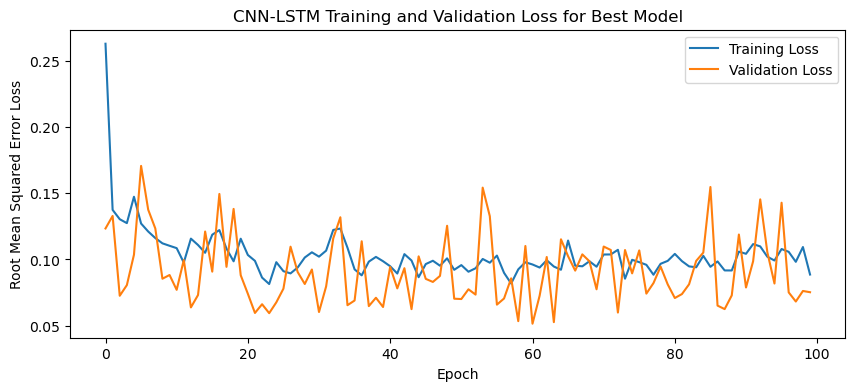

1/1 - 1s - loss: 0.1053 - 1s/epoch - 1s/step
Test Loss: 0.1053348183631897
Fold 2:
Epoch 1/100
19/19 [==============================] - 6s 107ms/step - loss: 0.2397 - val_loss: 0.1038
Epoch 2/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1308 - val_loss: 0.1700
Epoch 3/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1272 - val_loss: 0.1560
Epoch 4/100
19/19 [==============================] - 1s 51ms/step - loss: 0.1330 - val_loss: 0.1543
Epoch 5/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1569 - val_loss: 0.1587
Epoch 6/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1200 - val_loss: 0.0772
Epoch 7/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1070 - val_loss: 0.0698
Epoch 8/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1037 - val_loss: 0.1496
Epoch 9/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1055 - val_loss: 0.0887
Epoch 10/100
19/

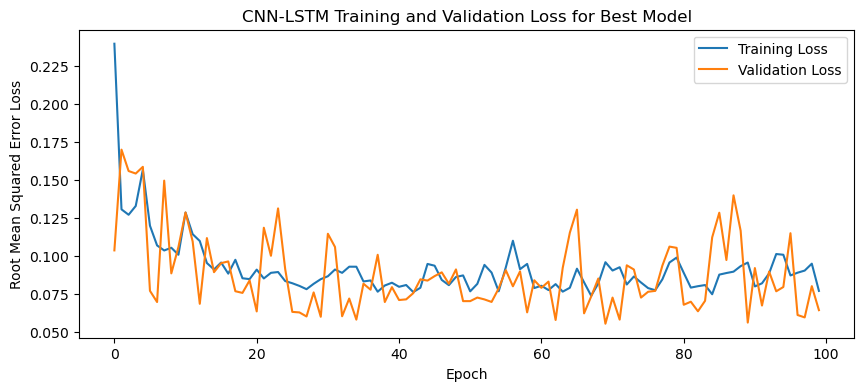

1/1 - 1s - loss: 0.1111 - 1s/epoch - 1s/step
Test Loss: 0.11114658415317535
Fold 3:
Epoch 1/100
19/19 [==============================] - 6s 117ms/step - loss: 0.2576 - val_loss: 0.1168
Epoch 2/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1609 - val_loss: 0.1161
Epoch 3/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1476 - val_loss: 0.1566
Epoch 4/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1147 - val_loss: 0.0855
Epoch 5/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1265 - val_loss: 0.1276
Epoch 6/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1087 - val_loss: 0.1430
Epoch 7/100
19/19 [==============================] - 1s 51ms/step - loss: 0.1108 - val_loss: 0.1086
Epoch 8/100
19/19 [==============================] - 1s 51ms/step - loss: 0.1051 - val_loss: 0.1053
Epoch 9/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1023 - val_loss: 0.1435
Epoch 10/100
19

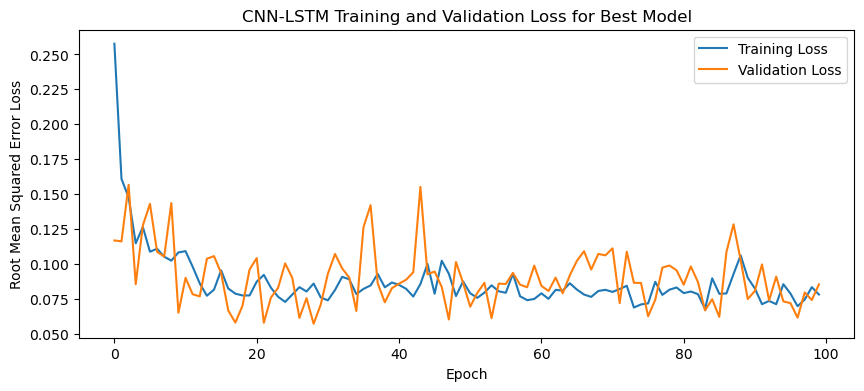

1/1 - 1s - loss: 0.0852 - 1s/epoch - 1s/step
Test Loss: 0.08516193926334381
Fold 4:
Epoch 1/100
20/20 [==============================] - 6s 101ms/step - loss: 0.3036 - val_loss: 0.2514
Epoch 2/100
20/20 [==============================] - 1s 47ms/step - loss: 0.1788 - val_loss: 0.1382
Epoch 3/100
20/20 [==============================] - 1s 47ms/step - loss: 0.1610 - val_loss: 0.1411
Epoch 4/100
20/20 [==============================] - 1s 47ms/step - loss: 0.1453 - val_loss: 0.1335
Epoch 5/100
20/20 [==============================] - 1s 48ms/step - loss: 0.1673 - val_loss: 0.1037
Epoch 6/100
20/20 [==============================] - 1s 48ms/step - loss: 0.1315 - val_loss: 0.1550
Epoch 7/100
20/20 [==============================] - 1s 48ms/step - loss: 0.1398 - val_loss: 0.1664
Epoch 8/100
20/20 [==============================] - 1s 49ms/step - loss: 0.1211 - val_loss: 0.0880
Epoch 9/100
20/20 [==============================] - 1s 49ms/step - loss: 0.1268 - val_loss: 0.0737
Epoch 10/100
20

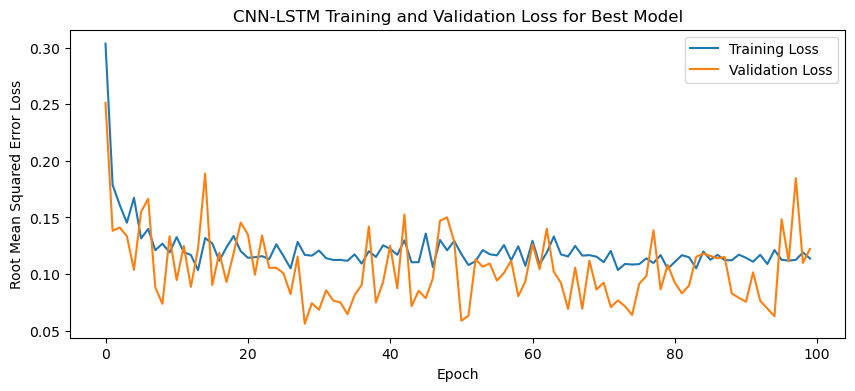

1/1 - 1s - loss: 0.0739 - 1s/epoch - 1s/step
Test Loss: 0.07393800467252731
Fold 5:
Epoch 1/100
19/19 [==============================] - 6s 106ms/step - loss: 0.2747 - val_loss: 0.2150
Epoch 2/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1252 - val_loss: 0.1552
Epoch 3/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1100 - val_loss: 0.1492
Epoch 4/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1173 - val_loss: 0.1043
Epoch 5/100
19/19 [==============================] - 1s 51ms/step - loss: 0.1055 - val_loss: 0.0958
Epoch 6/100
19/19 [==============================] - 1s 58ms/step - loss: 0.1136 - val_loss: 0.0855
Epoch 7/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1081 - val_loss: 0.1431
Epoch 8/100
19/19 [==============================] - 1s 48ms/step - loss: 0.0985 - val_loss: 0.1573
Epoch 9/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1092 - val_loss: 0.0754
Epoch 10/100
19

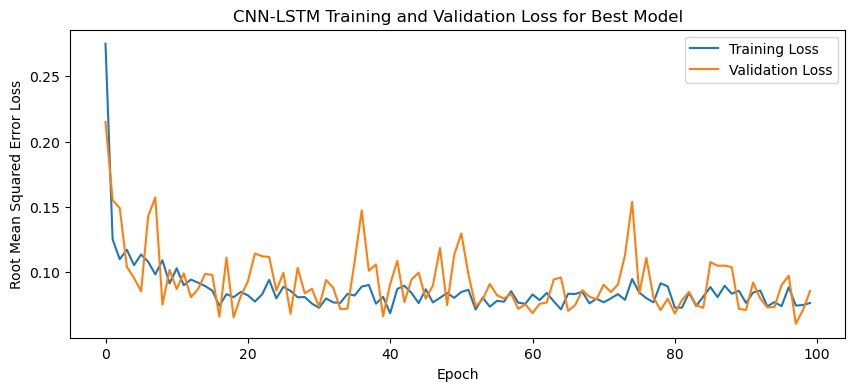

1/1 - 1s - loss: 0.0835 - 1s/epoch - 1s/step
Test Loss: 0.08349089324474335


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

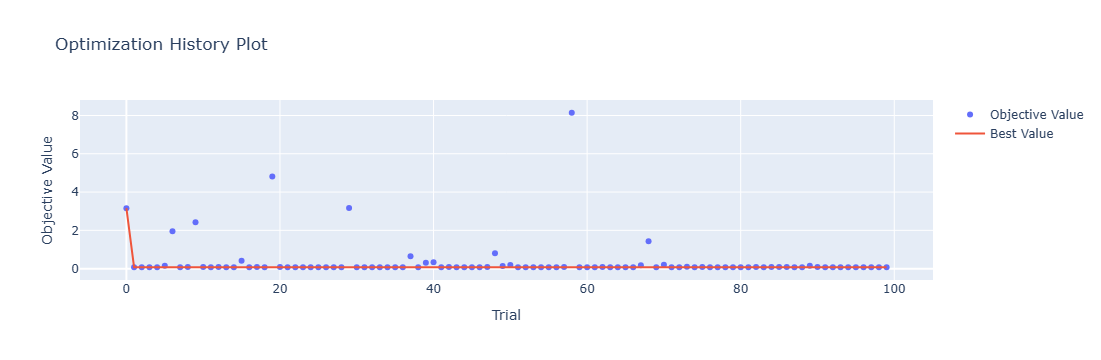

In [4]:
optuna.visualization.plot_optimization_history(study)

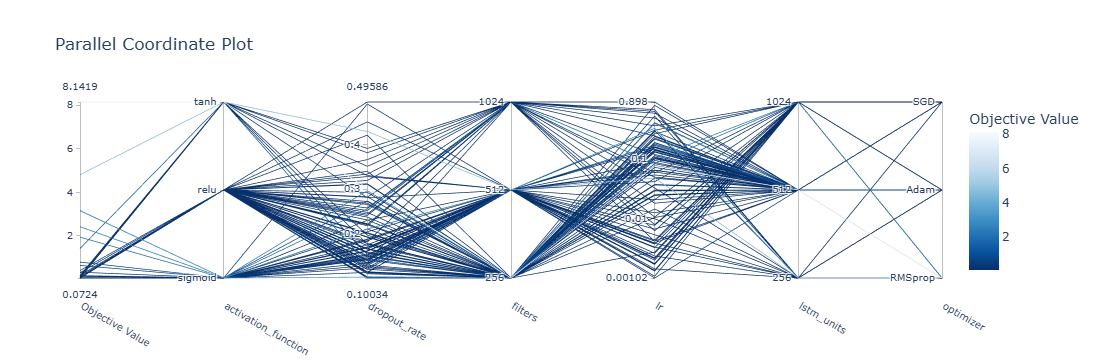

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

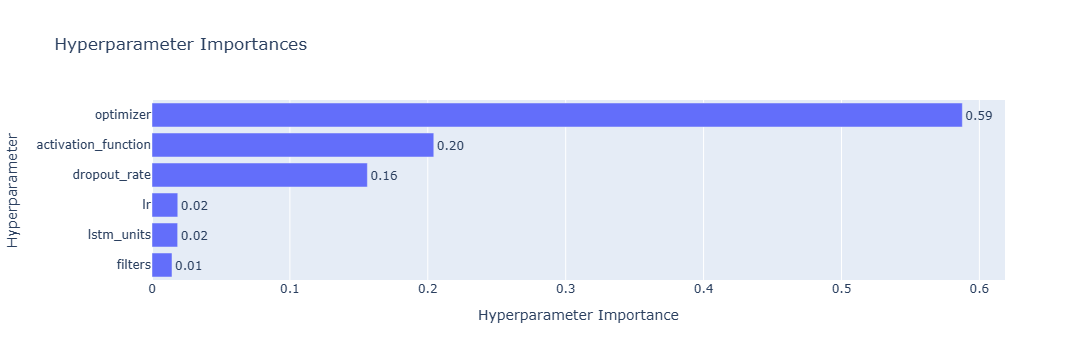

In [6]:
optuna.visualization.plot_param_importances(study)

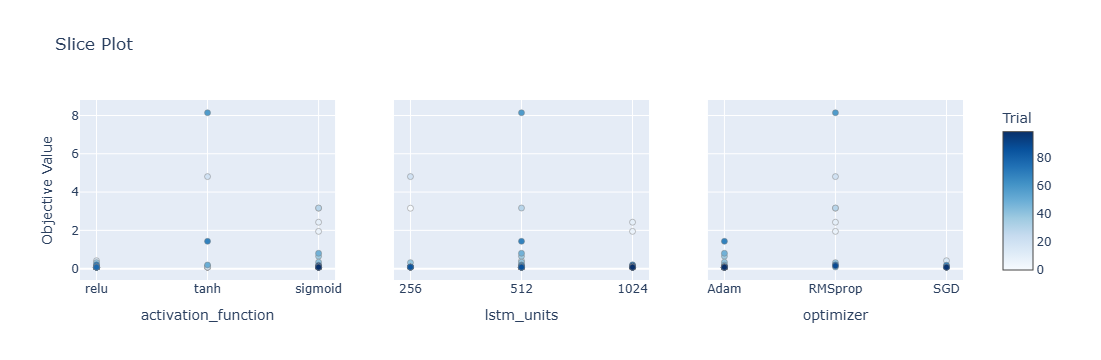

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

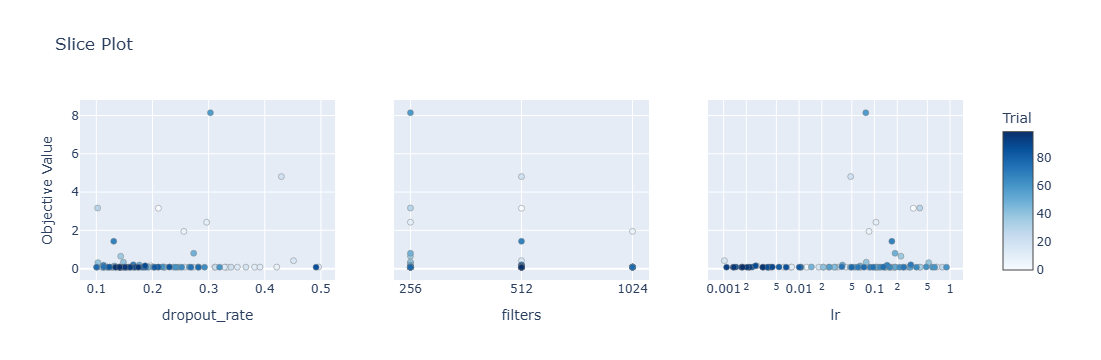

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 8s 154ms/step - loss: 0.2581 - accuracy: 0.1579 - mae: 0.2204 - rmse: 0.2581 - mape: 56.7997 - pearson: 0.1948 - val_loss: 0.1099 - val_accuracy: 0.3333 - val_mae: 0.0841 - val_rmse: 0.1099 - val_mape: 19.0455 - val_pearson: 0.1268
Epoch 2/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1245 - accuracy: 0.1579 - mae: 0.1051 - rmse: 0.1245 - mape: 26.9855 - pearson: 0.2441 - val_loss: 0.1028 - val_accuracy: 0.6667 - val_mae: 0.0808 - val_rmse: 0.1028 - val_mape: 19.0776 - val_pearson: 0.0042
Epoch 3/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1307 - accuracy:

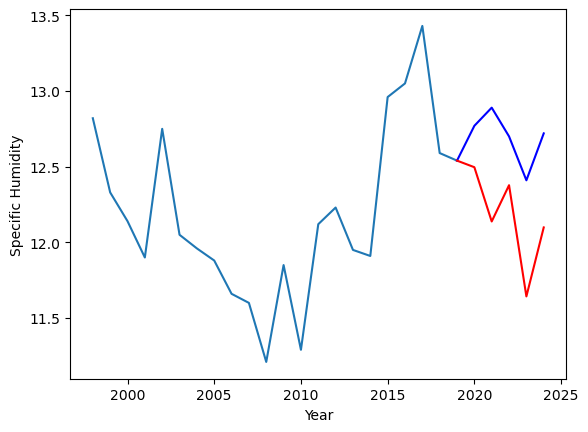

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.88		9.75		-0.13
10.09		9.39		-0.70
9.65		9.63		-0.02
9.13		8.89		-0.24
9.32		9.35		0.03


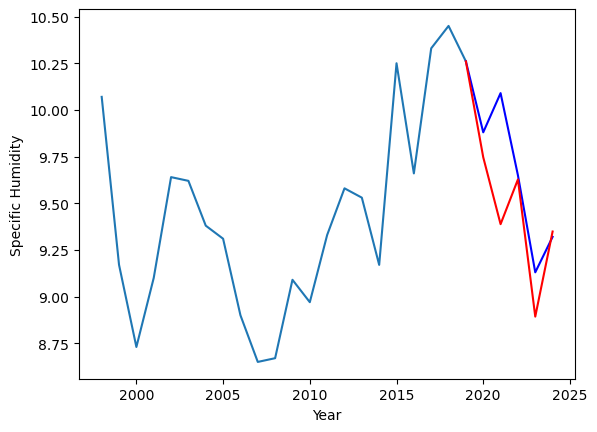

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.77  12.496484
1                1    9.88   9.746484


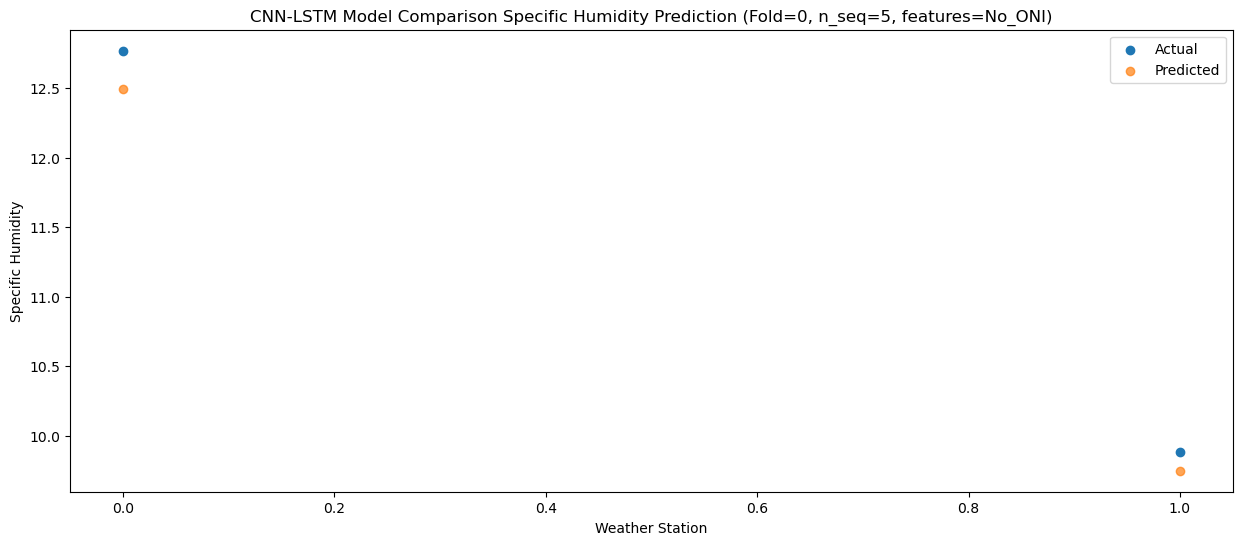

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.89  12.138009
1                1   10.09   9.388010


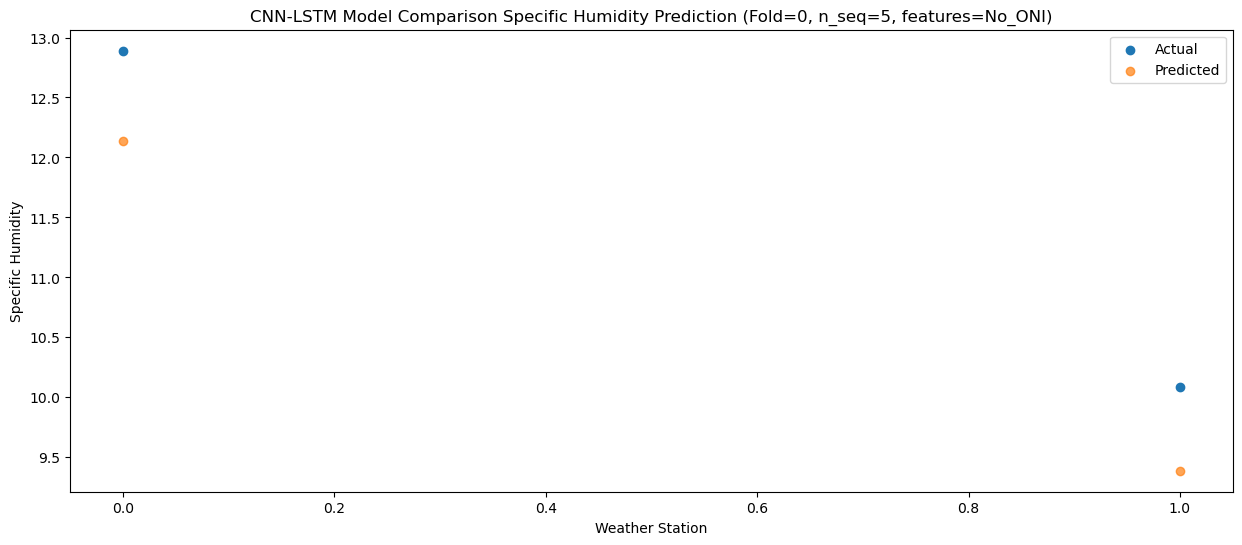

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.70  12.377571
1                1    9.65   9.627571


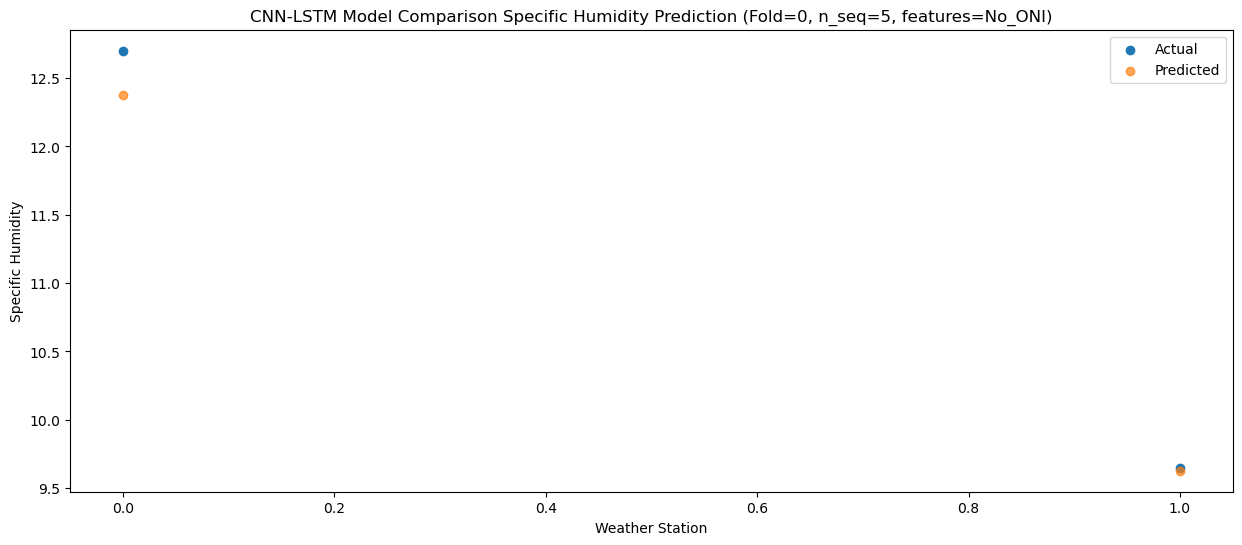

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.41  11.642817
1                1    9.13   8.892817


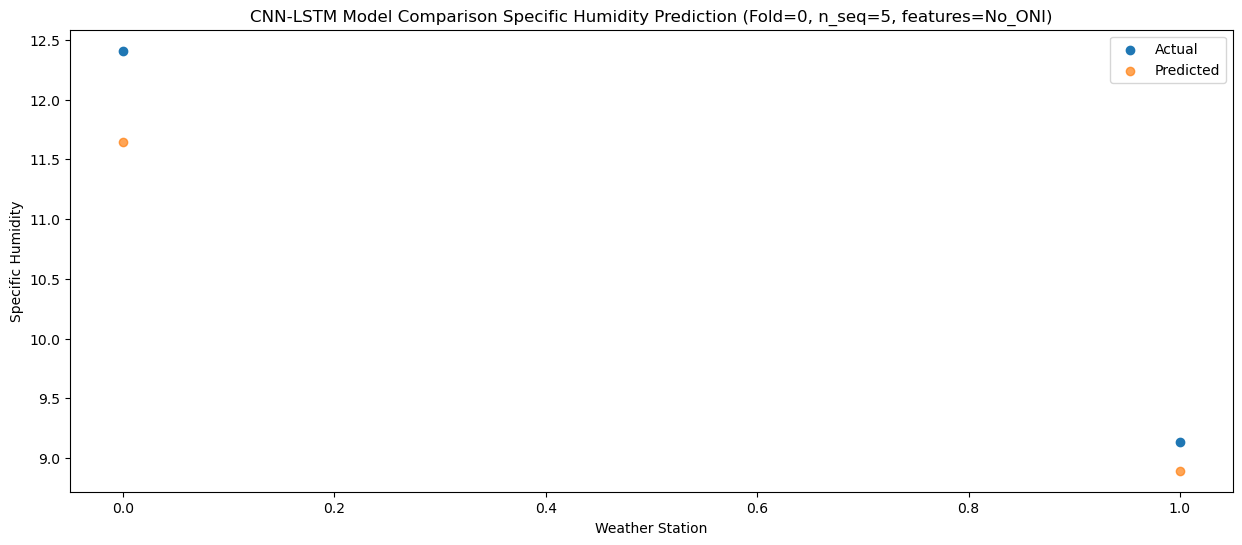

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.72  12.098584
1                1    9.32   9.348583


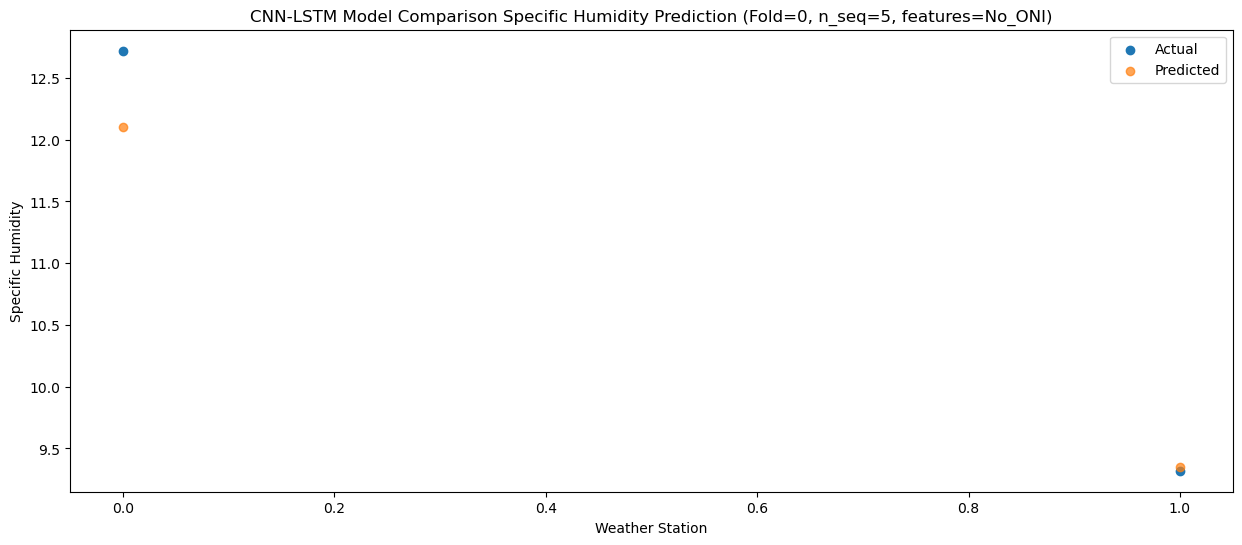

f, t:
[[12.77  9.88]
 [12.89 10.09]
 [12.7   9.65]
 [12.41  9.13]
 [12.72  9.32]]
[[12.49648378  9.7464839 ]
 [12.13800905  9.3880097 ]
 [12.37757095  9.62757134]
 [11.64281651  8.8928166 ]
 [12.09858357  9.34858339]]
Year at t+1:
t+1 SKRMSE: 0.215218
t+1 KRMSE: 0.215218
t+1 MAE: 0.203516
t+1 SKMAPE: 0.017466
t+1 R2_SCORE: 0.977817
t+1 KMAPE: 0.017466
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.325000
Year at t+2:
t+2 SKRMSE: 0.727420
t+2 KRMSE: 0.727420
t+2 MAE: 0.726991
t+2 SKMAPE: 0.063956
t+2 R2_SCORE: 0.730030
t+2 KMAPE: 0.063956
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 11.490000
Year at t+3:
t+3 SKRMSE: 0.228543
t+3 KRMSE: 0.228543
t+3 MAE: 0.172429
t+3 SKMAPE: 0.013856
t+3 R2_SCORE: 0.977541
t+3 KMAPE: 0.013856
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 11.175000
Year at t+4:
t+4 SKRMSE: 0.567814
t+4 KRMSE: 0.567814
t+4 MAE: 0.502183
t+4 SKMAPE: 0.043899
t+4 R2_SCORE: 0.880126
t+4 KMAPE: 0.043899
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 10.770000
Year at t+5:
t+5 SKRMSE: 0.439

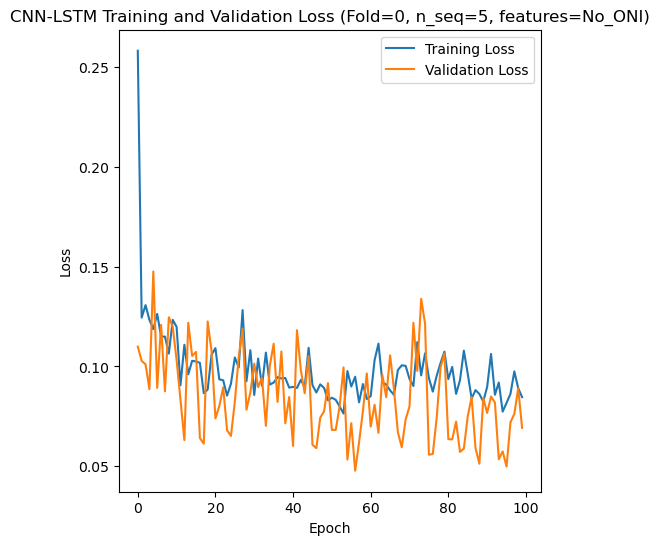

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 7s 135ms/step - loss: 0.2759 - accuracy: 0.2105 - mae: 0.2340 - rmse: 0.2759 - mape: 57.5586 - pearson: 0.2585 - val_loss: 0.1415 - val_accuracy: 0.0000e+00 - val_mae: 0.1223 - val_rmse: 0.1415 - val_mape: 31.9848 - val_pearson: 0.5311
Epoch 2/100
19/19 [==============================] - 1s 63ms/step - loss: 0.1313 - accuracy: 0.2105 - mae: 0.1090 - rmse: 0.1313 - mape: 27.7353 - pearson: 0.2252 - val_loss: 0.1300 - val_accuracy: 0.3333 - val_mae: 0.1149 - val_rmse: 0.1300 - val_mape: 29.2955 - val_pearson: 0.5451
Epoch 3/100
19/19 [==============================] - 1s 55ms/step - loss: 0.1434 - accur

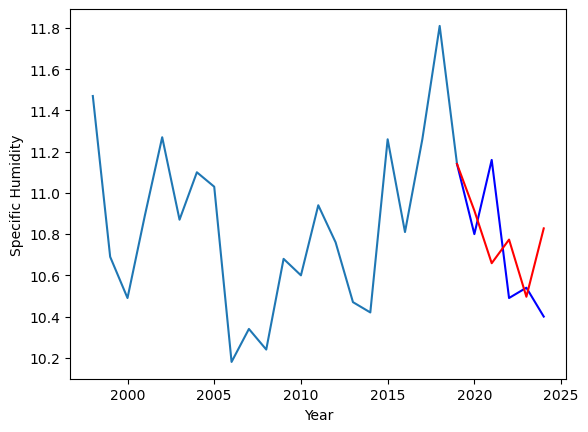

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.66		7.07		-0.59
6.92		6.82		-0.10
7.36		6.93		-0.43
6.79		6.66		-0.13
6.94		6.99		0.05


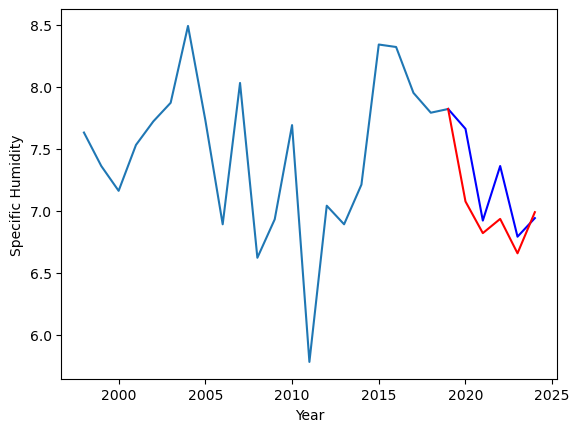

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  10.914117
1                1    7.66   7.074124


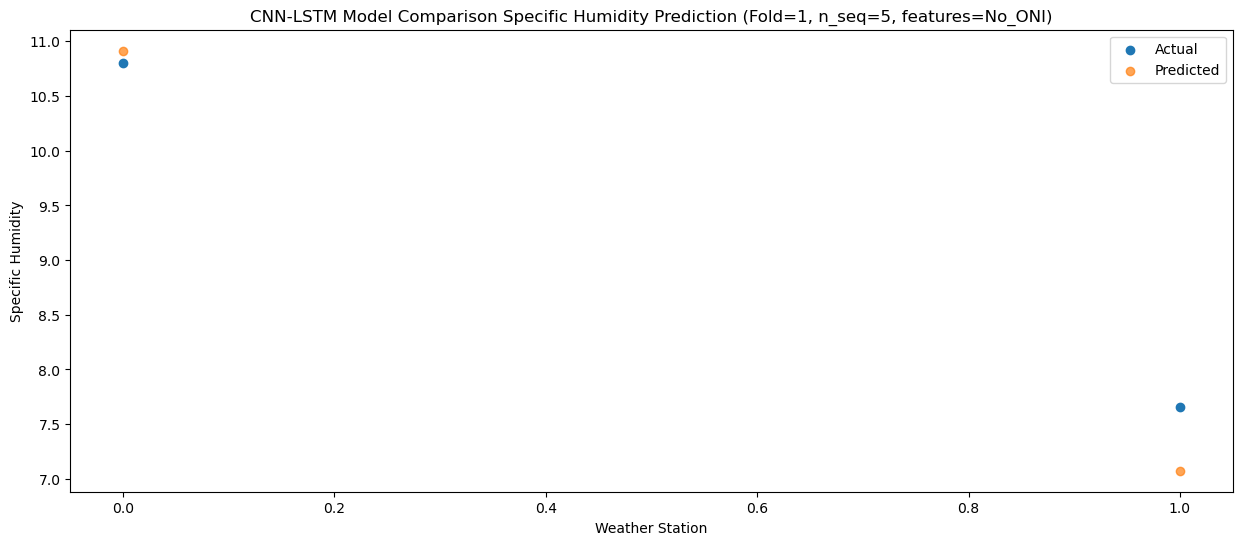

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.16  10.658836
1                1    6.92   6.818824


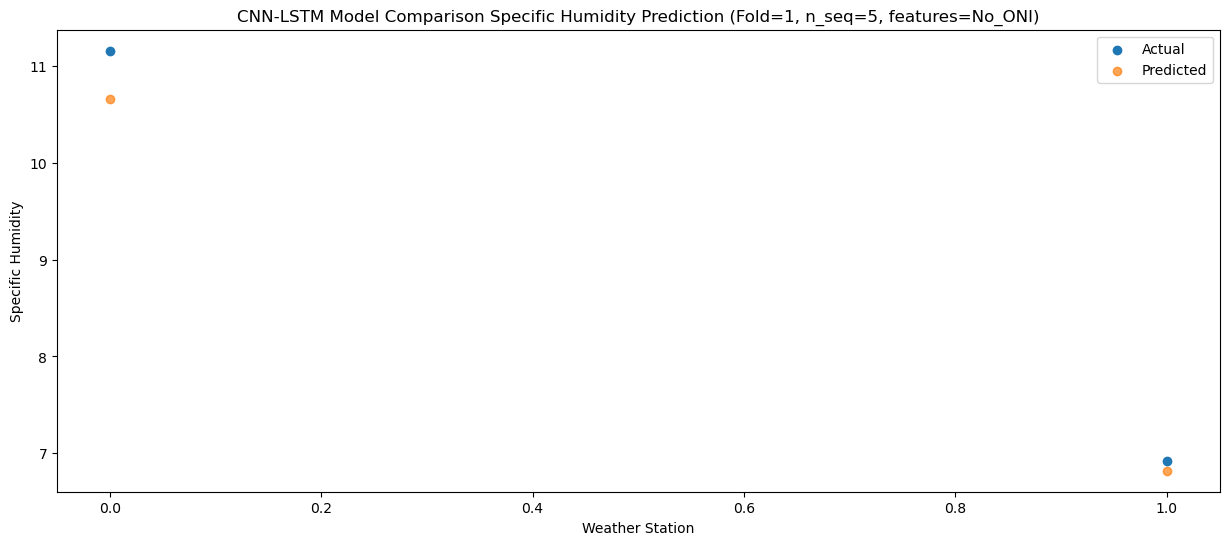

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.49  10.773542
1                1    7.36   6.933511


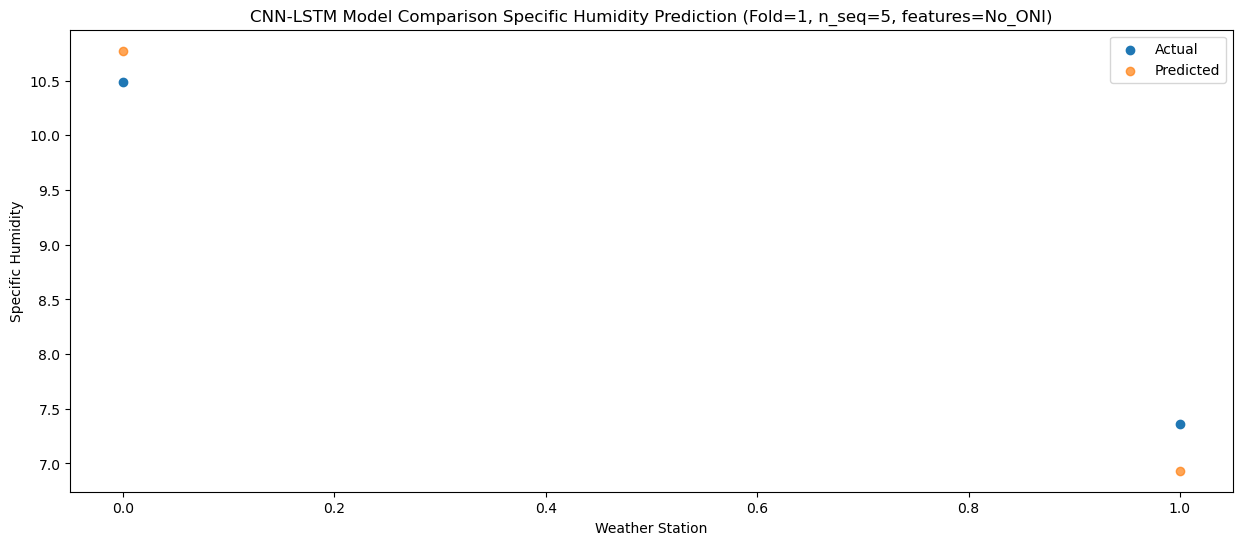

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.54  10.496086
1                1    6.79   6.656064


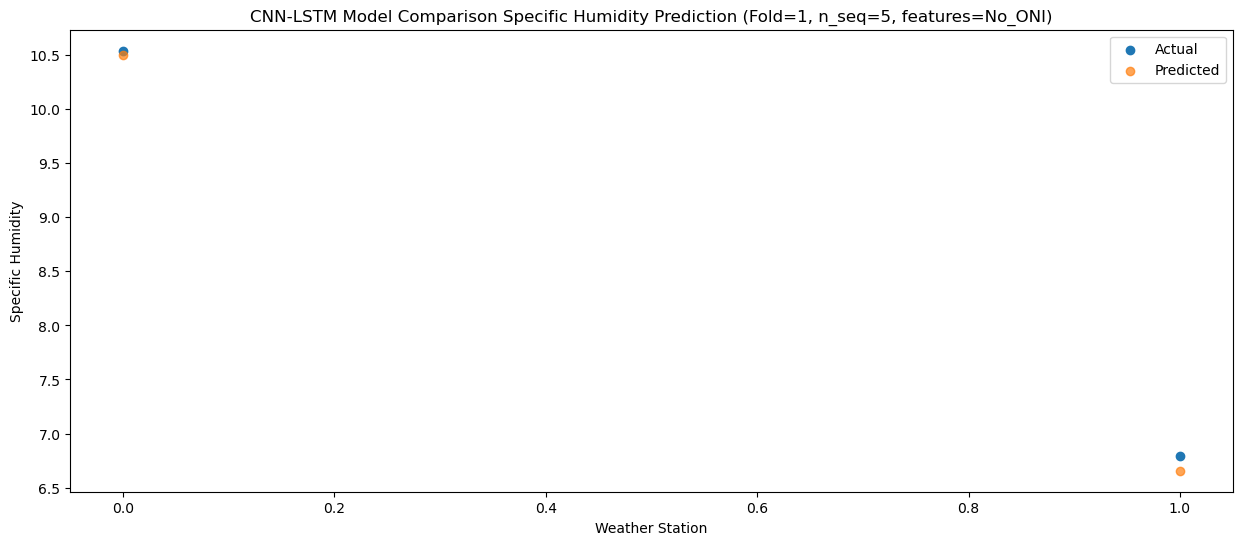

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   10.40  10.827840
1                1    6.94   6.987872


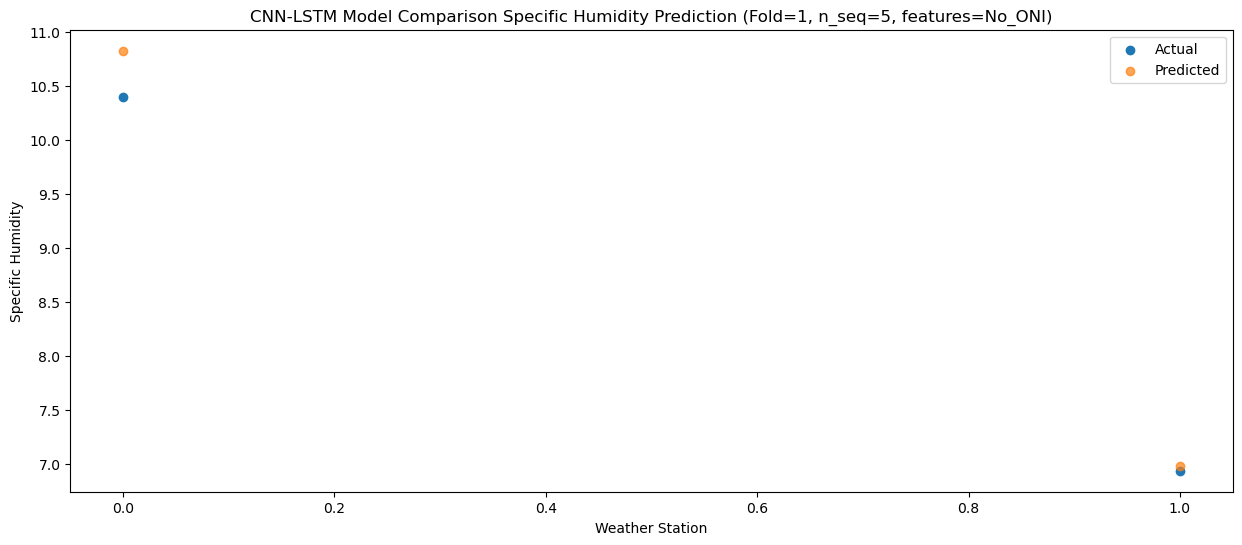

f, t:
[[10.8   7.66]
 [11.16  6.92]
 [10.49  7.36]
 [10.54  6.79]
 [10.4   6.94]]
[[10.91411701  7.07412374]
 [10.65883607  6.81882394]
 [10.77354247  6.93351133]
 [10.49608649  6.65606449]
 [10.82784001  6.98787163]]
Year at t+1:
t+1 SKRMSE: 0.422063
t+1 KRMSE: 0.422063
t+1 MAE: 0.349997
t+1 SKMAPE: 0.043526
t+1 R2_SCORE: 0.927731
t+1 KMAPE: 0.043526
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.230000
Year at t+2:
t+2 SKRMSE: 0.361526
t+2 KRMSE: 0.361526
t+2 MAE: 0.301170
t+2 SKMAPE: 0.029764
t+2 R2_SCORE: 0.970919
t+2 KMAPE: 0.029764
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.040000
Year at t+3:
t+3 SKRMSE: 0.362139
t+3 KRMSE: 0.362139
t+3 MAE: 0.355016
t+3 SKMAPE: 0.042488
t+3 R2_SCORE: 0.946455
t+3 KMAPE: 0.042488
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.925000
Year at t+4:
t+4 SKRMSE: 0.099667
t+4 KRMSE: 0.099667
t+4 MAE: 0.088925
t+4 SKMAPE: 0.011946
t+4 R2_SCORE: 0.997174
t+4 KMAPE: 0.011946
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.665000
Year at t+5:
t+5 SKRMSE: 0.304416


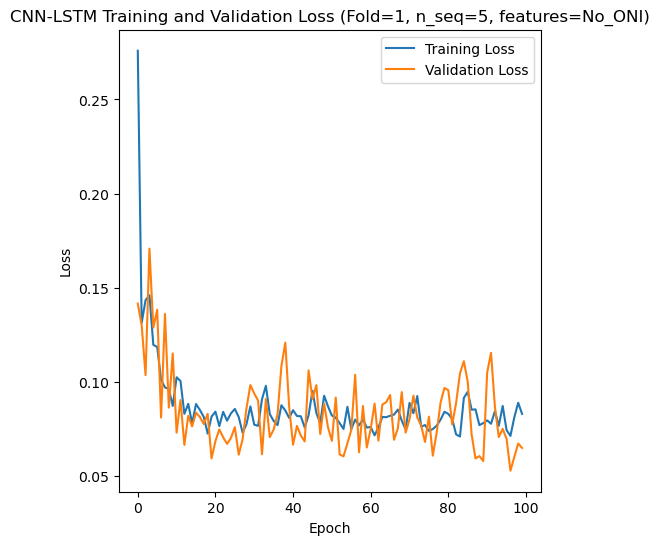

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 6s 117ms/step - loss: 0.2801 - accuracy: 0.1579 - mae: 0.2437 - rmse: 0.2801 - mape: 60.6286 - pearson: 0.3635 - val_loss: 0.1104 - val_accuracy: 0.6667 - val_mae: 0.0860 - val_rmse: 0.1104 - val_mape: 21.8538 - val_pearson: 0.7129
Epoch 2/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1309 - accuracy: 0.2105 - mae: 0.1132 - rmse: 0.1309 - mape: 27.4060 - pearson: 0.2256 - val_loss: 0.0927 - val_accuracy: 0.6667 - val_mae: 0.0849 - val_rmse: 0.0927 - val_mape: 19.2094 - val_pearson: 0.7896
Epoch 3/100
19/19 [==============================] - 1s 51ms/step - loss: 0.1496 - accuracy:

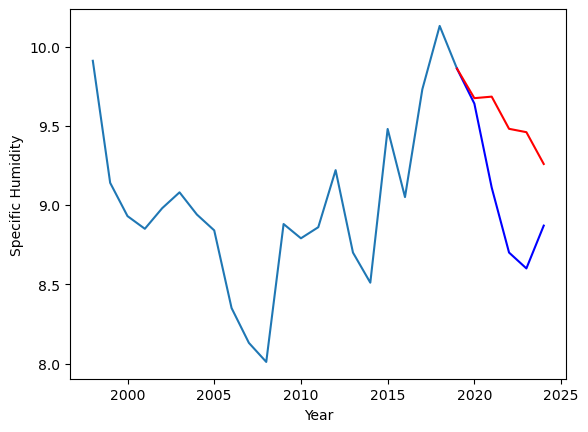

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.84		8.25		0.41
7.66		8.26		0.60
7.73		8.06		0.33
8.00		8.04		0.04
8.01		7.84		-0.17


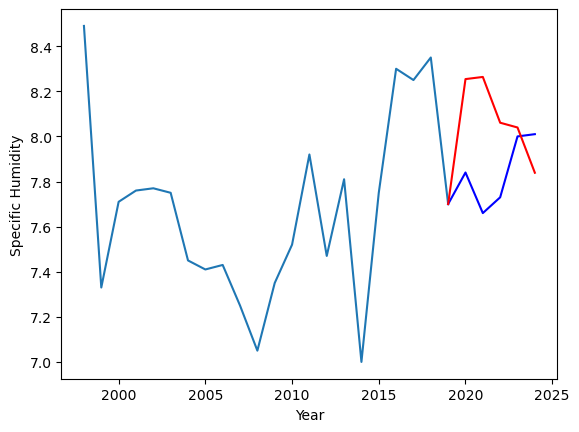

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.64   9.674209
1                1    7.84   8.254194


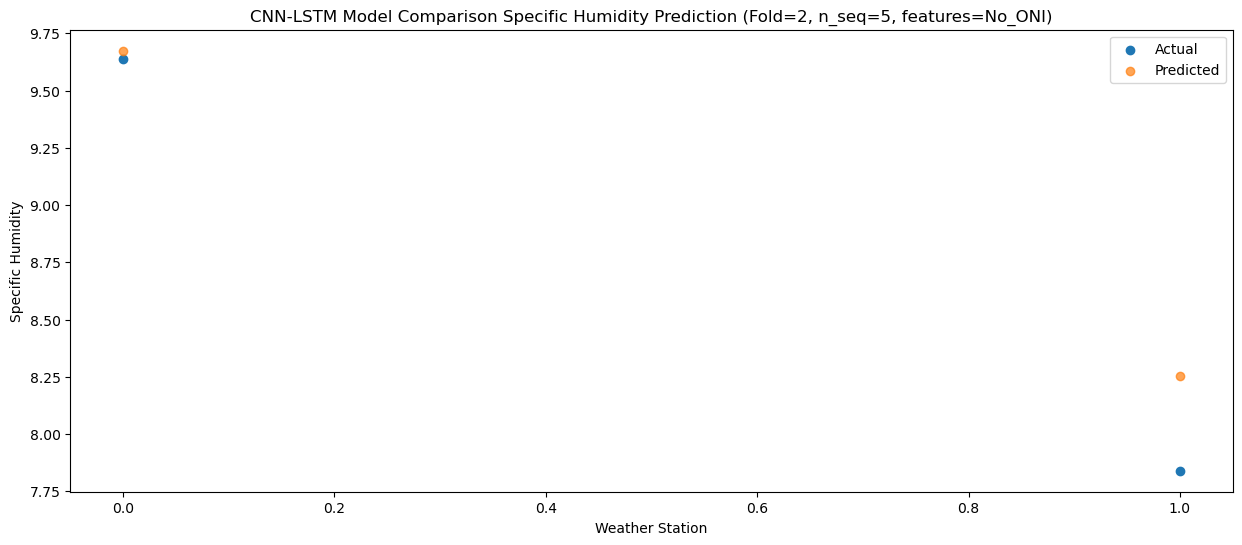

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    9.11   9.683800
1                1    7.66   8.263758


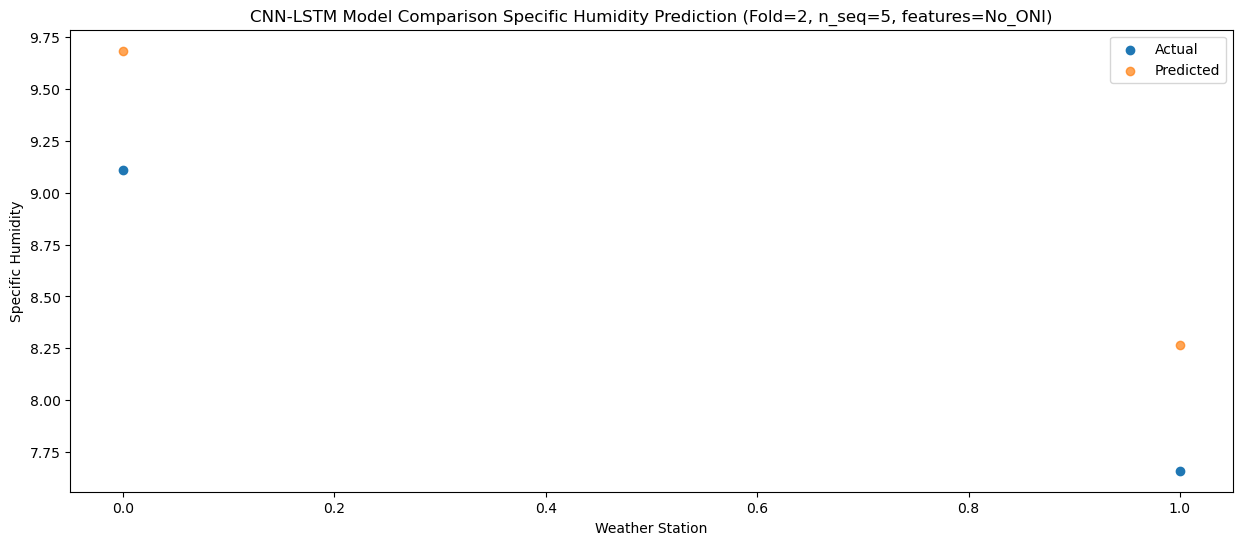

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    8.70   9.480762
1                1    7.73   8.060746


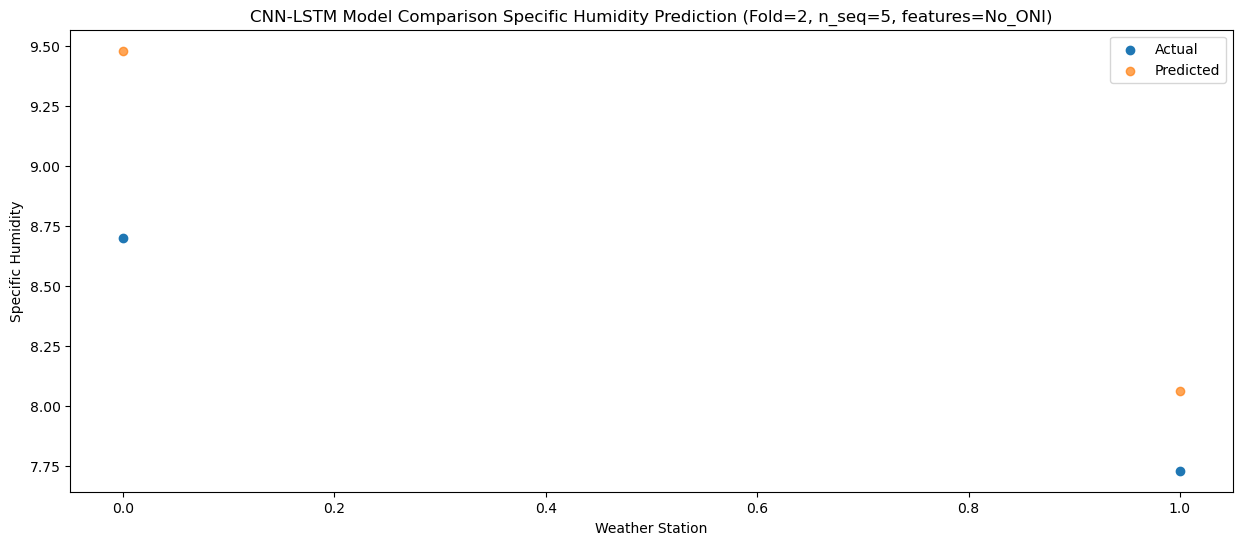

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0     8.6   9.459602
1                1     8.0   8.039577


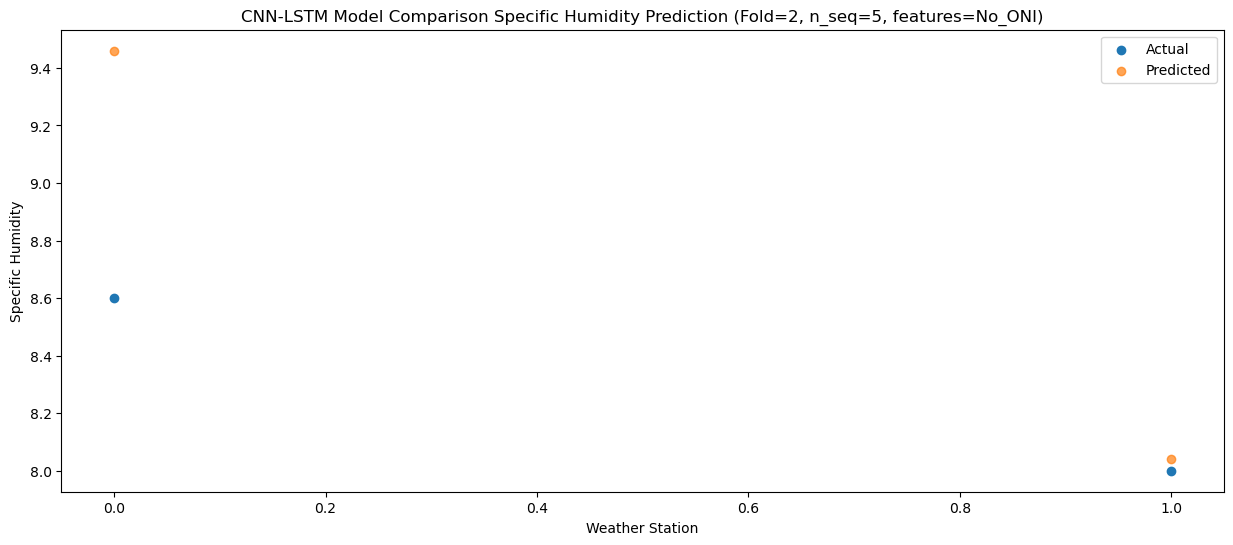

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    8.87   9.258936
1                1    8.01   7.838857


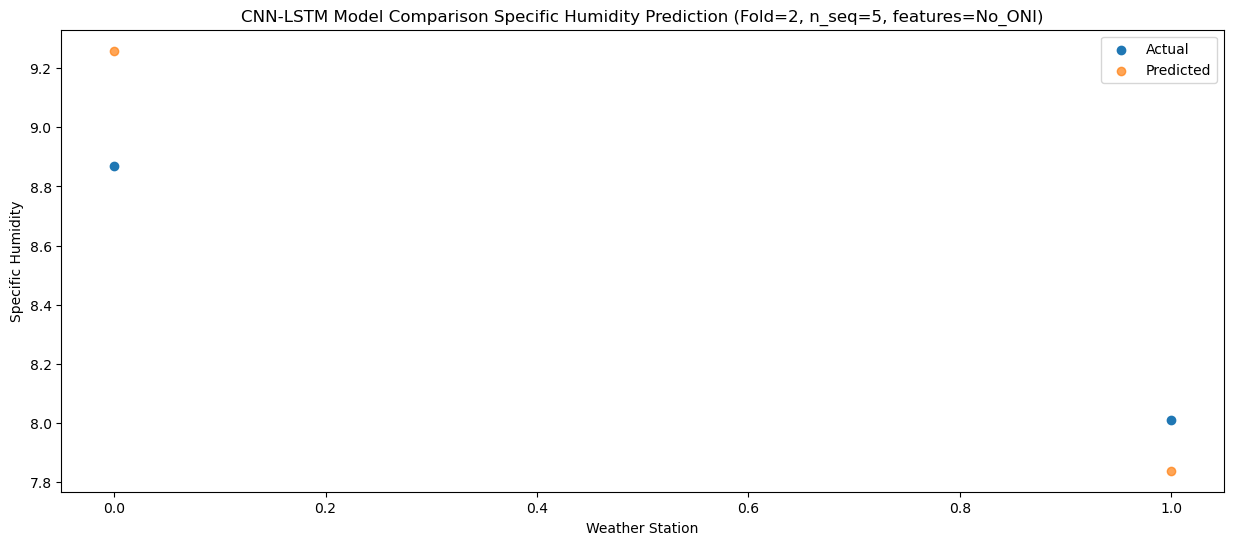

f, t:
[[9.64 7.84]
 [9.11 7.66]
 [8.7  7.73]
 [8.6  8.  ]
 [8.87 8.01]]
[[9.67420914 8.25419368]
 [9.6838001  8.26375756]
 [9.48076219 8.06074646]
 [9.45960189 8.03957727]
 [9.25893555 7.83885732]]
Year at t+1:
t+1 SKRMSE: 0.293876
t+1 KRMSE: 0.293876
t+1 MAE: 0.224201
t+1 SKMAPE: 0.028190
t+1 R2_SCORE: 0.893379
t+1 KMAPE: 0.028190
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.740000
Year at t+2:
t+2 SKRMSE: 0.588969
t+2 KRMSE: 0.588969
t+2 MAE: 0.588779
t+2 SKMAPE: 0.070903
t+2 R2_SCORE: 0.340053
t+2 KMAPE: 0.070903
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 8.385000
Year at t+3:
t+3 SKRMSE: 0.599576
t+3 KRMSE: 0.599576
t+3 MAE: 0.555754
t+3 SKMAPE: 0.066265
t+3 R2_SCORE: -0.528287
t+3 KMAPE: 0.066265
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.215000
Year at t+4:
t+4 SKRMSE: 0.608474
t+4 KRMSE: 0.608474
t+4 MAE: 0.449590
t+4 SKMAPE: 0.052450
t+4 R2_SCORE: -3.113788
t+4 KMAPE: 0.052450
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.300000
Year at t+5:
t+5 SKRMSE: 0.300467
t+5 KRMSE: 0.30046

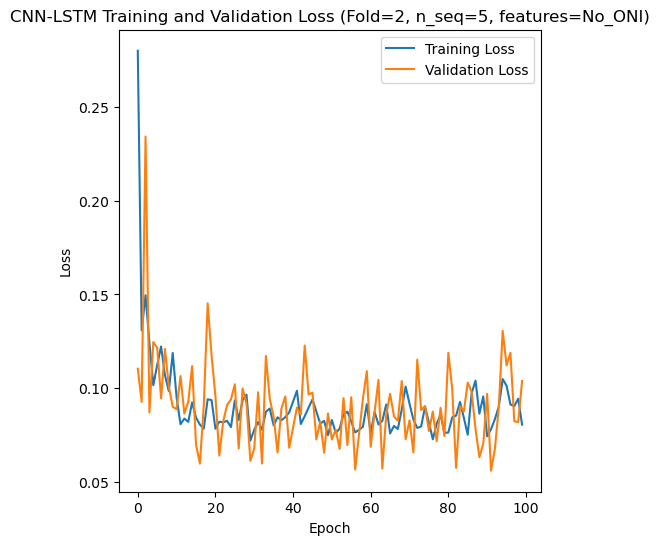

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 6s 118ms/step - loss: 0.2397 - accuracy: 0.1000 - mae: 0.2005 - rmse: 0.2397 - mape: 35.6261 - pearson: 0.3287 - val_loss: 0.1496 - val_accuracy: 0.0000e+00 - val_mae: 0.1315 - val_rmse: 0.1496 - val_mape: 22.3685 - val_pearson: 0.4046
Epoch 2/100
20/20 [==============================] - 1s 48ms/step - loss: 0.1832 - accuracy: 0.1000 - mae: 0.1516 - rmse: 0.1832 - mape: 27.9401 - pearson: 0.3494 - val_loss: 0.2394 - val_accuracy: 0.5000 - val_mae: 0.1995 - val_rmse: 0.2394 - val_mape: 34.7216 - val_pearson: 0.5264
Epoch 3/100
20/20 [==============================] - 1s 59ms/step - loss: 0.1951 - accuracy: 0.4000 - mae: 0.1597 - rmse: 0.1951 - mape: 30.0853 -

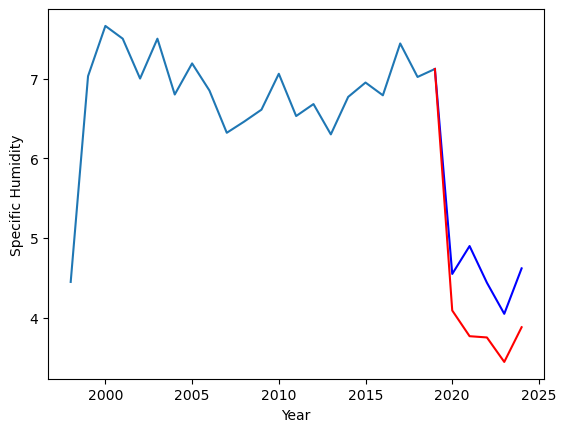

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.21		7.97		-0.24
8.12		7.65		-0.47
8.09		7.63		-0.46
7.62		7.33		-0.29
7.64		7.76		0.12


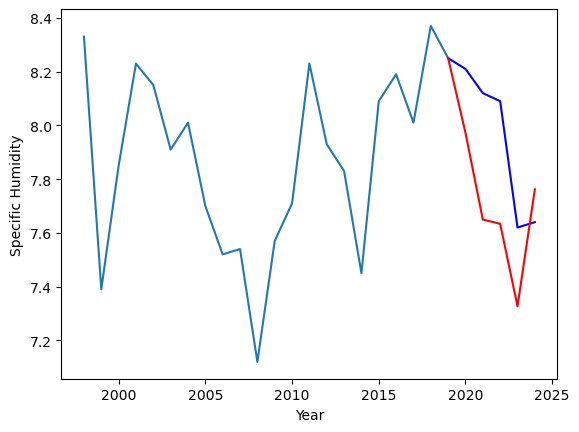

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.55   4.091931
1                1    8.21   7.971931


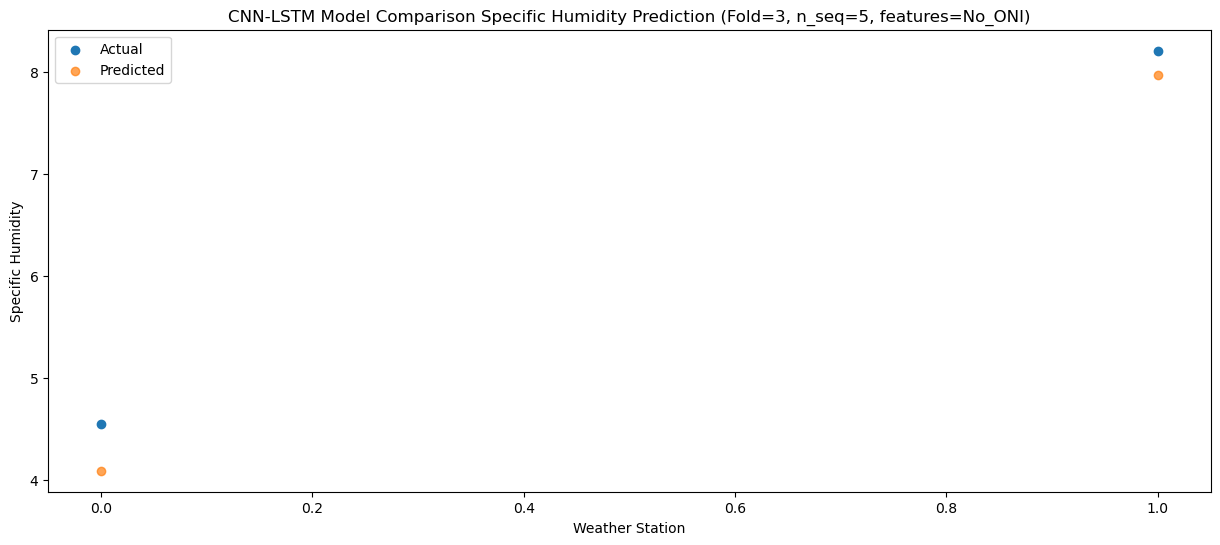

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    4.90   3.769509
1                1    8.12   7.649509


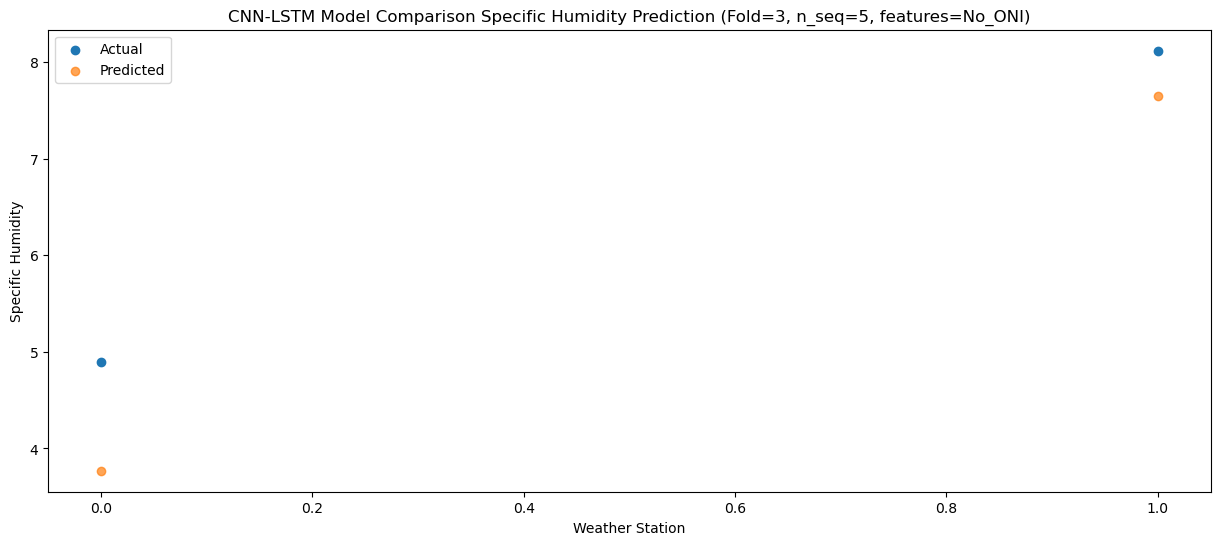

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.44   3.753729
1                1    8.09   7.633729


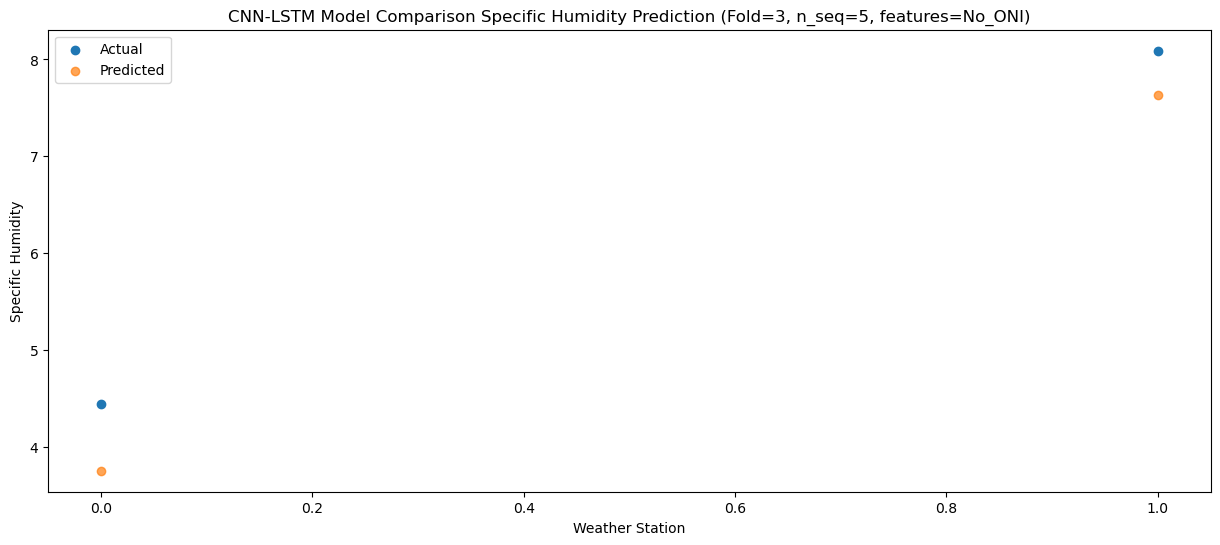

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    4.05   3.446931
1                1    7.62   7.326931


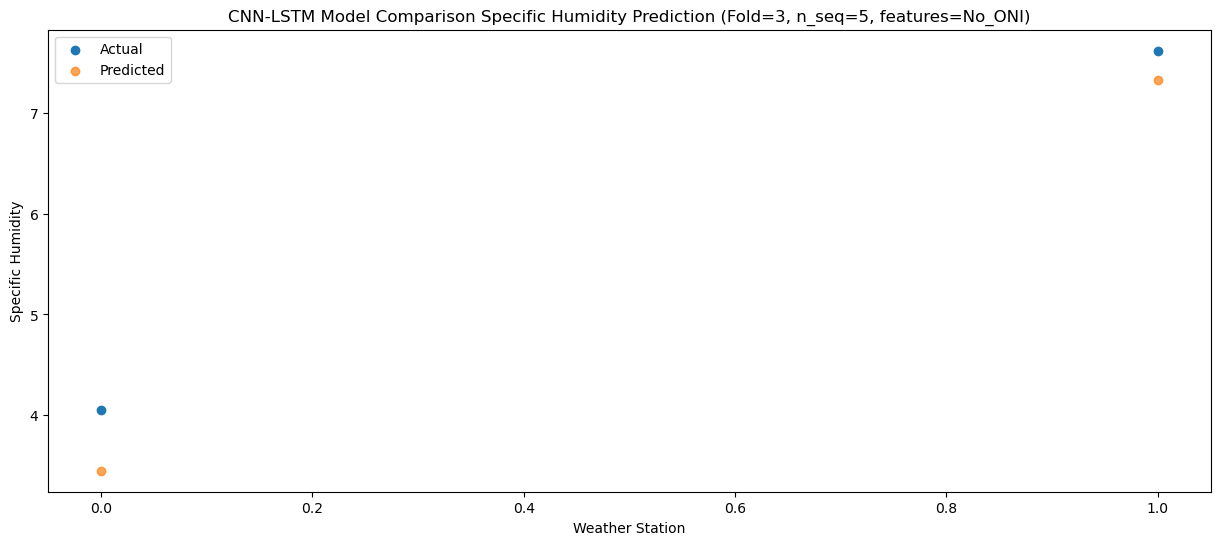

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    4.62    3.88205
1                1    7.64    7.76205


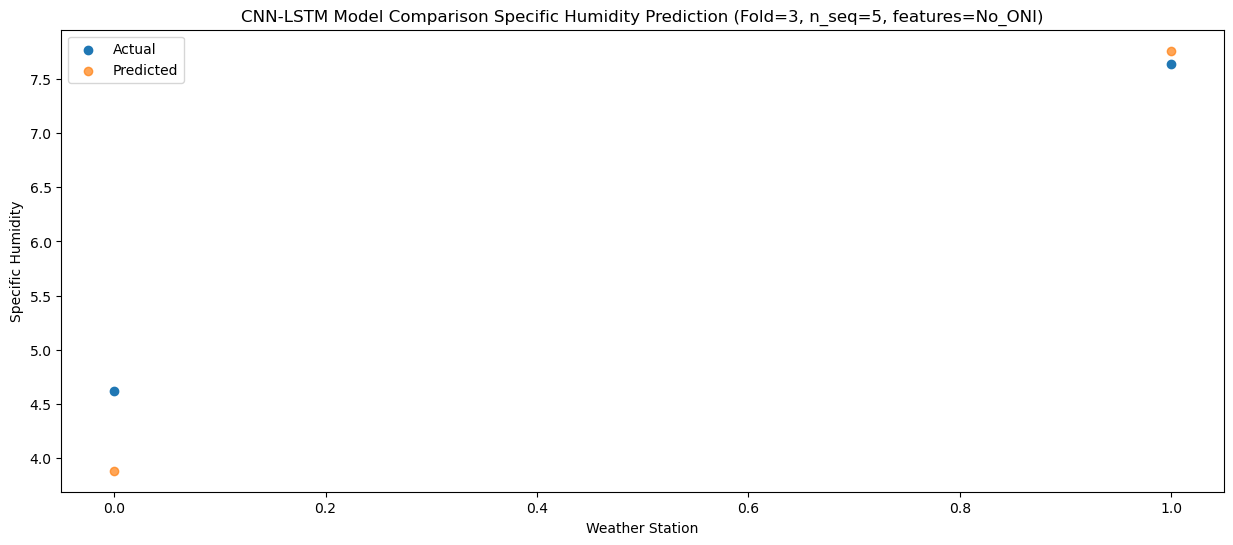

f, t:
[[4.55 8.21]
 [4.9  8.12]
 [4.44 8.09]
 [4.05 7.62]
 [4.62 7.64]]
[[4.09193135 7.97193135]
 [3.76950915 7.64950915]
 [3.75372893 7.63372893]
 [3.44693053 7.32693053]
 [3.88205025 7.76205025]]
Year at t+1:
t+1 SKRMSE: 0.365037
t+1 KRMSE: 0.365037
t+1 MAE: 0.348069
t+1 SKMAPE: 0.064836
t+1 R2_SCORE: 0.960210
t+1 KMAPE: 0.064836
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.380000
Year at t+2:
t+2 SKRMSE: 0.865844
t+2 KRMSE: 0.865844
t+2 MAE: 0.800491
t+2 SKMAPE: 0.144327
t+2 R2_SCORE: 0.710781
t+2 KMAPE: 0.144327
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.510000
Year at t+3:
t+3 SKRMSE: 0.582731
t+3 KRMSE: 0.582731
t+3 MAE: 0.571271
t+3 SKMAPE: 0.105482
t+3 R2_SCORE: 0.898044
t+3 KMAPE: 0.105482
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.265000
Year at t+4:
t+4 SKRMSE: 0.474122
t+4 KRMSE: 0.474122
t+4 MAE: 0.448069
t+4 SKMAPE: 0.093683
t+4 R2_SCORE: 0.929449
t+4 KMAPE: 0.093683
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 5.835000
Year at t+5:
t+5 SKRMSE: 0.528898
t+5 KRMSE: 0.528898


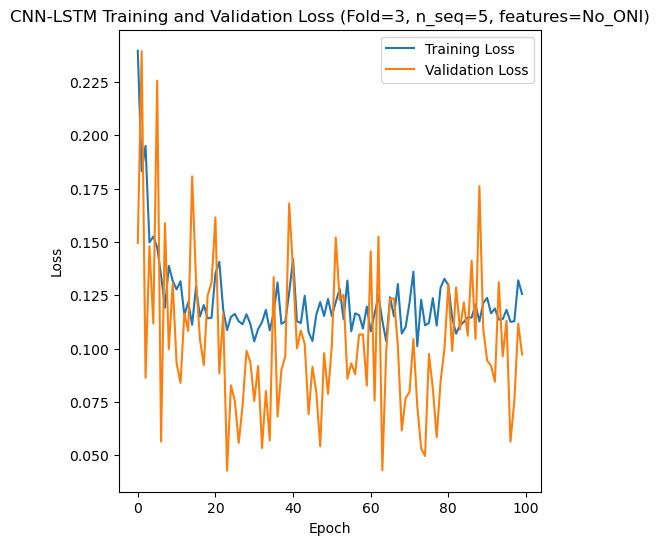

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 7s 150ms/step - loss: 0.2767 - accuracy: 0.1053 - mae: 0.2266 - rmse: 0.2767 - mape: 56.4533 - pearson: 0.2389 - val_loss: 0.1556 - val_accuracy: 0.6667 - val_mae: 0.1244 - val_rmse: 0.1556 - val_mape: 29.1911 - val_pearson: 0.1164
Epoch 2/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1284 - accuracy: 0.3158 - mae: 0.1092 - rmse: 0.1284 - mape: 26.4835 - pearson: 0.2393 - val_loss: 0.2250 - val_accuracy: 0.3333 - val_mae: 0.1987 - val_rmse: 0.2250 - val_mape: 48.6281 - val_pearson: 0.0263
Epoch 3/100
19/19 [==============================] - 1s 57ms/step - loss: 0.1521 - accuracy: 

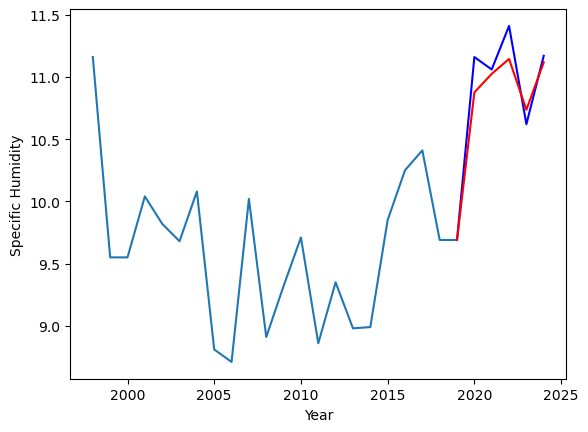

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.79		8.05		0.26
7.52		8.19		0.67
7.85		8.31		0.46
7.25		7.91		0.66
7.48		8.29		0.81


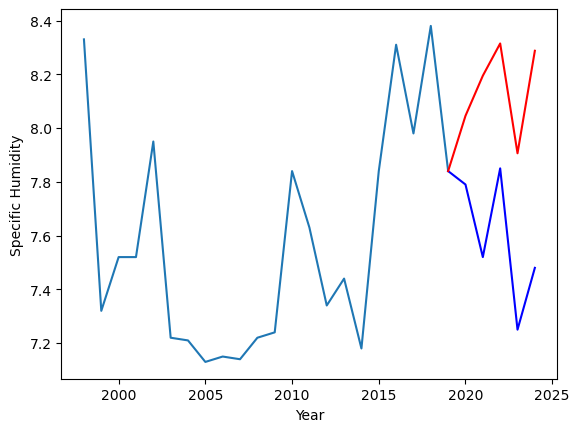

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.16  10.875632
1                1    7.79   8.045587


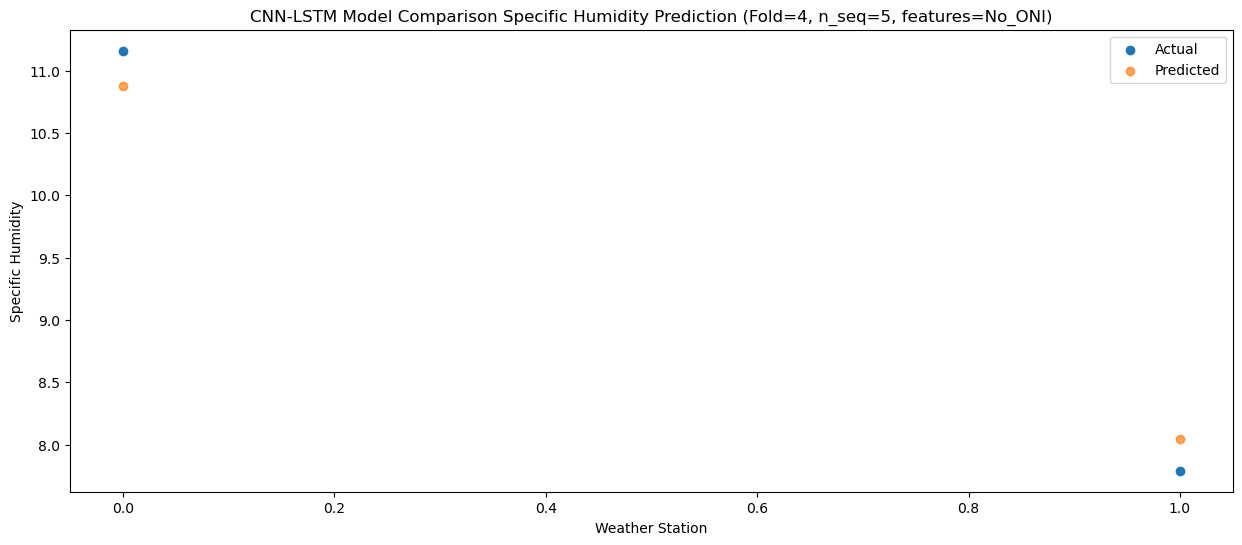

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.06  11.024785
1                1    7.52   8.194741


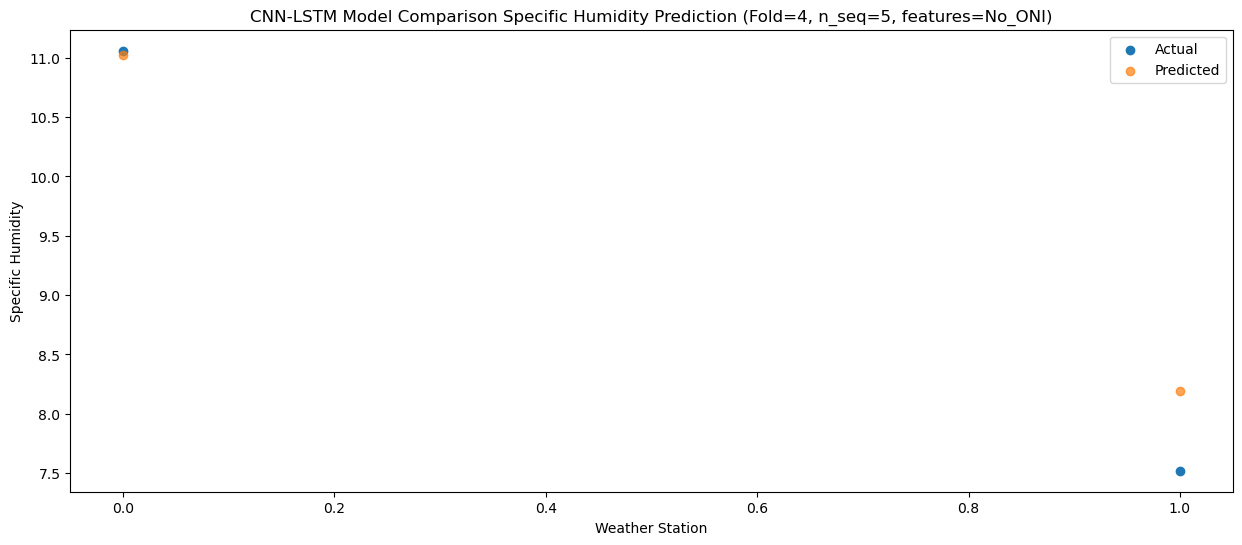

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.41  11.144749
1                1    7.85   8.314735


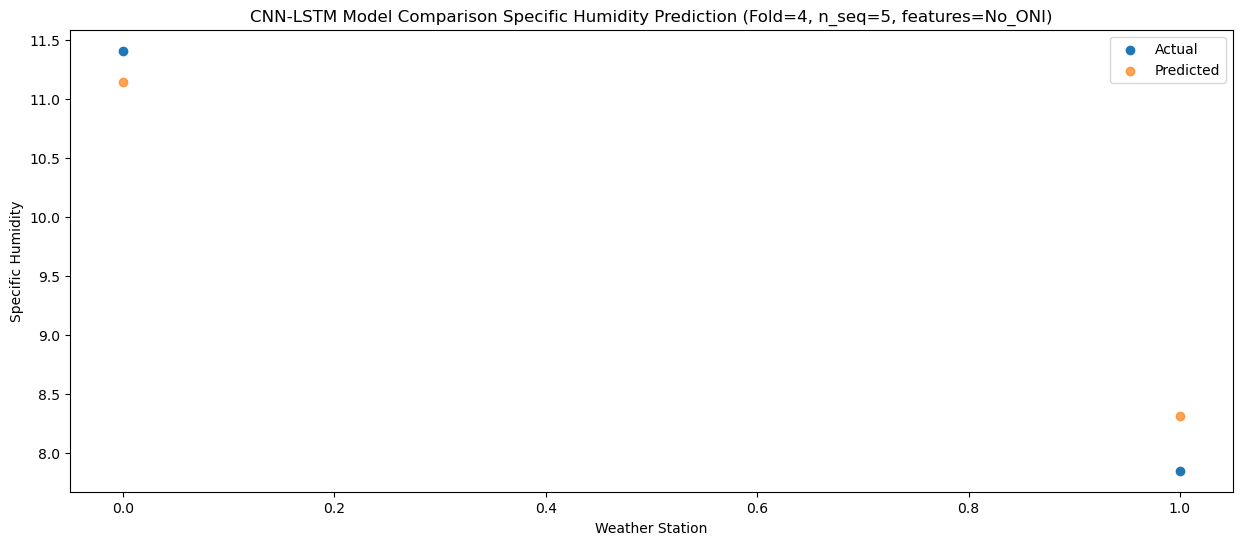

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.62  10.736248
1                1    7.25   7.906210


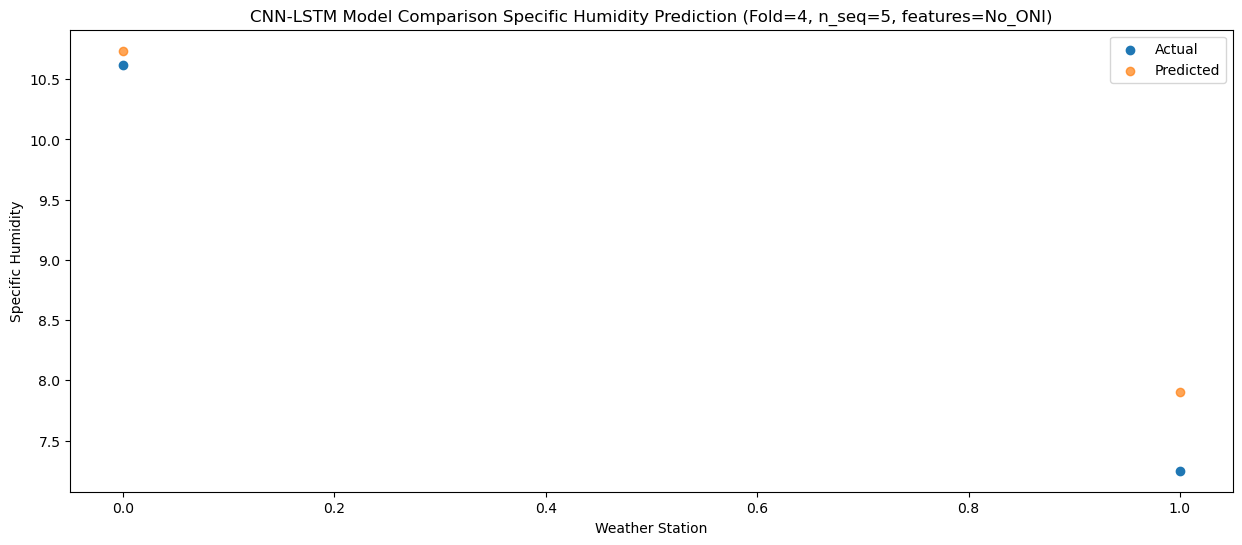

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.17  11.117591
1                1    7.48   8.287582


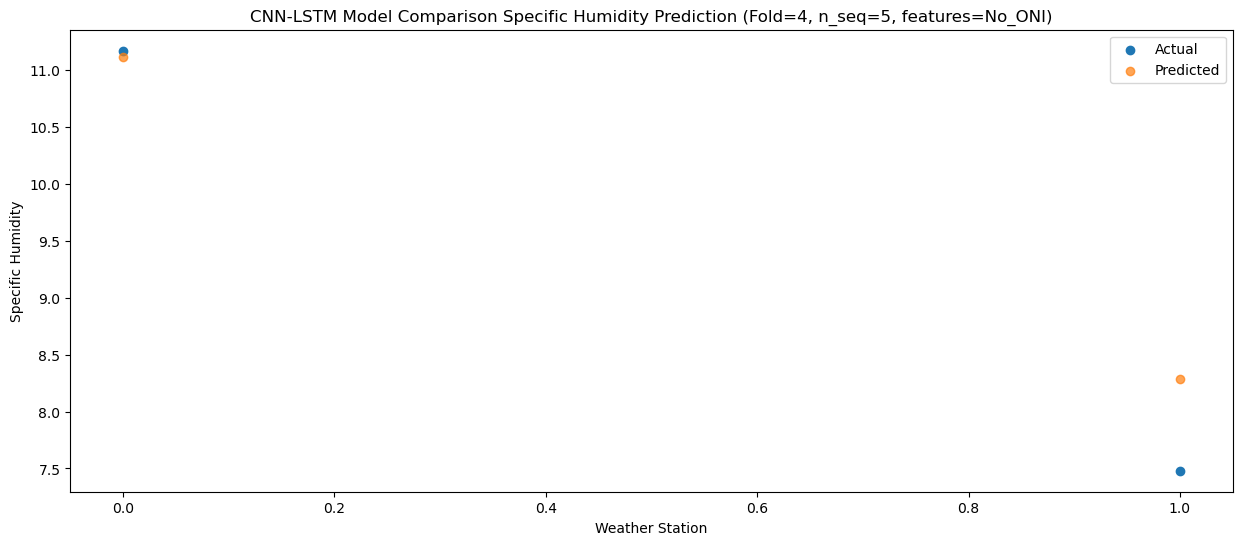

f, t:
[[11.16  7.79]
 [11.06  7.52]
 [11.41  7.85]
 [10.62  7.25]
 [11.17  7.48]]
[[10.87563202  8.04558741]
 [11.02478473  8.19474149]
 [11.14474877  8.31473493]
 [10.73624801  7.90620967]
 [11.11759134  8.28758227]]
Year at t+1:
t+1 SKRMSE: 0.270361
t+1 KRMSE: 0.270361
t+1 MAE: 0.269978
t+1 SKMAPE: 0.029145
t+1 R2_SCORE: 0.974255
t+1 KMAPE: 0.029145
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.475000
Year at t+2:
t+2 SKRMSE: 0.477764
t+2 KRMSE: 0.477764
t+2 MAE: 0.354978
t+2 SKMAPE: 0.046455
t+2 R2_SCORE: 0.927142
t+2 KMAPE: 0.046455
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.290000
Year at t+3:
t+3 SKRMSE: 0.378376
t+3 KRMSE: 0.378376
t+3 MAE: 0.364993
t+3 SKMAPE: 0.041225
t+3 R2_SCORE: 0.954814
t+3 KMAPE: 0.041225
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.630000
Year at t+4:
t+4 SKRMSE: 0.471235
t+4 KRMSE: 0.471235
t+4 MAE: 0.386229
t+4 SKMAPE: 0.050729
t+4 R2_SCORE: 0.921788
t+4 KMAPE: 0.050729
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.935000
Year at t+5:
t+5 SKRMSE: 0.572248


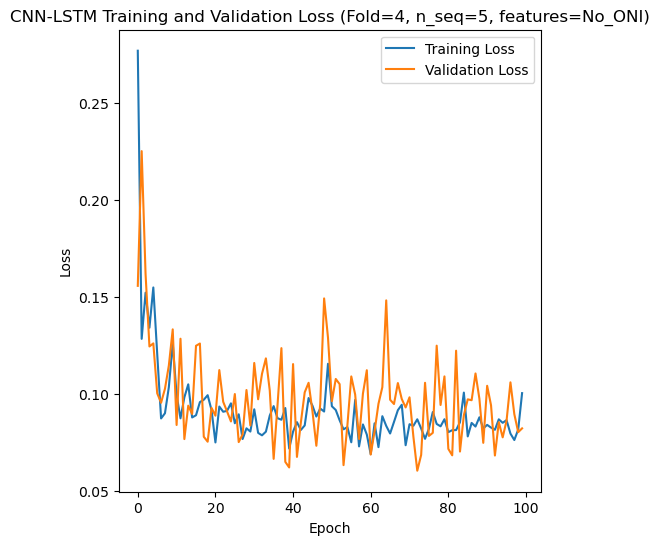

[[0.47824510916571666], [0.3294192410123548], [0.500651745278268], [0.5877137586935398], [0.4458815494766891]]
[[array(0.47824511)], [array(0.32941924)], [array(0.50065175)], [array(0.58771376)], [array(0.44588155)]]
[[0.3860238001346591], [0.2665925060510636], [0.4196726535558704], [0.5195800059735781], [0.36123469164967564]]
[[0.033027535754532274], [0.030348430428739265], [0.05008303438379931], [0.09923625614962325], [0.044776540127676026]]
[[0.9067309841757475], [0.9664119629081758], [0.3752812143586224], [0.8849096016246627], [0.936492236144662]]
[[array(0.03302754)], [array(0.03034843)], [array(0.05008303)], [array(0.09923626)], [array(0.04477654)]]
[[array(0.97360119)], [array(0.97596785)], [array(0.80773447)], [array(0.98458465)], [array(0.99030894)]]
[12.77 12.89 12.7  12.41 12.72  9.88 10.09  9.65  9.13  9.32 10.8  11.16
 10.49 10.54 10.4   7.66  6.92  7.36  6.79  6.94  9.64  9.11  8.7   8.6
  8.87  7.84  7.66  7.73  8.    8.01  4.55  4.9   4.44  4.05  4.62  8.21
  8.12  8.09

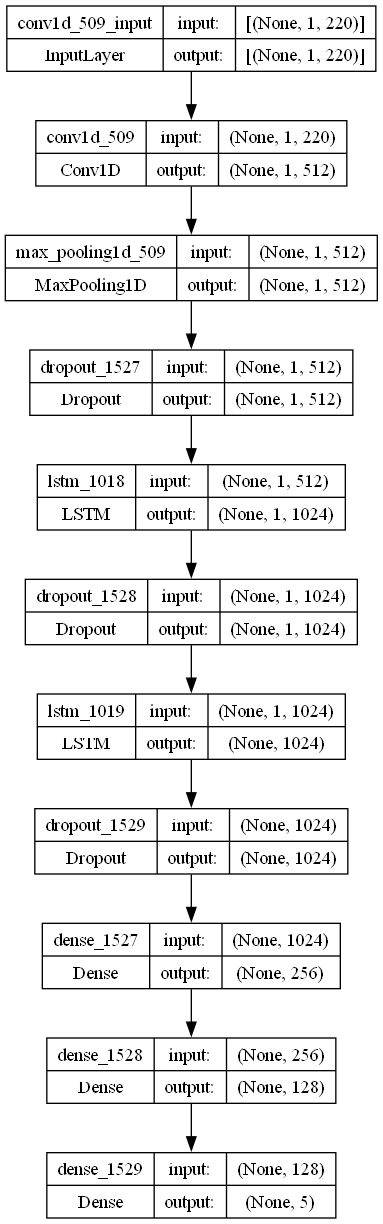

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 512
    lr = 0.003788791155708196
    optimizer = Adam(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 1024
    dropout_rate = 0.14562954245961326

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

   
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S5_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)